In [1]:
# imports
import numpy as np
import pandas as pd
import requests
import logging
import pickle

# finance
import yfinance as yf
import pandas_datareader as pdr
import talib as ta

# visualisation
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# time
import time
from datetime import date, datetime, timedelta 

# maschine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from collections import Counter
import xgboost as xgb

# 0. Getting Data

In [2]:
# downloading crypto from binance
def get_coins():
        # set up logging to display info and error messages
        logging.basicConfig(
            level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
        )

        # list of coins
        coins = [
             #biggest coins
            "BTCUSDT",
            "ETHUSDT",
            "XRPUSDT",
            "BNBUSDT",
            "SOLUSDT",
            "DOGEUSDT",
            "ADAUSDT",
            "TRXUSDT",
            "MKRUSDT",
            "AAVEUSDT",
            #stablecoin
            "USDCUSDT", 
            "TUSDUSDT",
            "FDUSDUSDT",
            "EURUSDT",
            "EURUSDC"
        ]

        def fetch_crypto_ohlc(coin, interval="1h"):
            url = "https://api.binance.com/api/v1/klines"
        
            # 90 days back from today as it is max for binance api
            start_time = datetime.now() - timedelta(days=90)
            end_time = datetime.now()

            all_data = []

            while start_time < end_time:
                # define request parameters for binance api
                params = {
                    "symbol": coin,
                    "interval": interval,
                    "startTime": int(start_time.timestamp() * 1000),
                    "endTime": int(
                        (start_time + timedelta(days=30)).timestamp() * 1000
                    ),  # fetching 30 days at a time
                }

                response = requests.get(url, params=params)

                # check if request was successful
                if response.status_code != 200:
                    logging.error(f"Error fetching data for {coin}: {response.status_code}")
                    break

                data = response.json()

                # check if data is returned
                if not data:
                    logging.warning(f"No OHLC data found for {coin}.")
                    break

                all_data.extend(data)

                # update start time for next request
                start_time = pd.to_datetime(data[-1][0], unit="ms") + timedelta(
                    milliseconds=1
                )

                logging.info(f"Fetched data for {coin} up to {start_time}")
                time.sleep(0.5)  # pause to avoid api limits

            if not all_data:
                return pd.DataFrame()

            # convert data into df with appropriate column names
            ohlc_df = pd.DataFrame(
                all_data,
                columns=[
                    "timestamp",
                    "open",
                    "high",
                    "low",
                    "close",
                    "volume",
                    "close_time",
                    "quote_asset_volume",
                    "number_of_trades",
                    "taker_buy_base_asset_volume",
                    "taker_buy_quote_asset_volume",
                    "ignore",
                ],
            )

            # columns
            stablecoins = [ "USDCUSDT", "TUSDUSDT", "FDUSDUSDT", "EURUSDT", "EURUSDC"]
            ohlc_df["ticker"] = coin
            ohlc_df["ticker_type"] = "stablecoin" if coin in stablecoins else "cryptocurrency"
            ohlc_df['ticker_type'] = ohlc_df['ticker_type'].astype('category')

            # convert price and volume to float
            ohlc_df[["open", "high", "low", "close", "volume"]] = ohlc_df[["open", "high", "low", "close", "volume"]].astype(float)
            ohlc_df["price_change"] = (ohlc_df["close"] - ohlc_df["open"]) / ohlc_df["open"] * 100

            # setting the timezone to Berlin
            ohlc_df["date"] = pd.to_datetime(ohlc_df["timestamp"], unit="ms")
            ohlc_df["date"] = (
                ohlc_df["date"].dt.tz_localize("UTC").dt.tz_convert("Europe/Berlin")
            )
            ohlc_df.set_index("date", inplace=True)

            return ohlc_df[
                [
                    "ticker",
                    "ticker_type",
                    "open",
                    "high",
                    "low",
                    "close",
                    "price_change",
                    "volume"
                ]
            ]

        def generate_datetime_features(df):
            # generate additional datetime features
            df["year"] = df.index.year.astype(int)
            df["month"] = df.index.month.astype(int)
            df["day"] = df.index.weekday.astype(int)
            df["hour"] = df.index.hour.astype(int)

            return df

        # main script
        all_data = pd.DataFrame()

        for coin in coins:
            logging.info(f"Fetching data for {coin}")
            df = fetch_crypto_ohlc(coin)

            if not df.empty:
                df = generate_datetime_features(df)
                all_data = pd.concat([all_data, df])
            else:
                logging.warning(f"No data fetched for {coin}")

        # reorder columns to have datetime features at the beginning
        datetime_features = ["year", "month", "day", "hour", "ticker", "ticker_type"]
        other_columns = [col for col in all_data.columns if col not in datetime_features]
        all_data = all_data[datetime_features + other_columns]

        all_data['ticker'] = all_data['ticker'].astype('category')

        # save df to csv
        all_data.to_csv('db/crypto.csv', index=True)
        logging.info("Data fetching and processing complete. Data saved to crypto.csv")

        all_data.info()

        all_data.describe()

if __name__ == "__main__":
        get_coins()

2025-01-16 16:17:56,610 - INFO - Fetching data for BTCUSDT
2025-01-16 16:17:56,999 - INFO - Fetched data for BTCUSDT up to 2024-11-08 10:00:00.001000
2025-01-16 16:17:57,883 - INFO - Fetched data for BTCUSDT up to 2024-11-29 06:00:00.001000
2025-01-16 16:17:58,737 - INFO - Fetched data for BTCUSDT up to 2024-12-20 02:00:00.001000
2025-01-16 16:17:59,623 - INFO - Fetched data for BTCUSDT up to 2025-01-09 22:00:00.001000
2025-01-16 16:18:00,543 - INFO - Fetched data for BTCUSDT up to 2025-01-16 15:00:00.001000
2025-01-16 16:18:01,462 - WARNING - No OHLC data found for BTCUSDT.
2025-01-16 16:18:01,513 - INFO - Fetching data for ETHUSDT
2025-01-16 16:18:01,874 - INFO - Fetched data for ETHUSDT up to 2024-11-08 10:00:00.001000
2025-01-16 16:18:02,717 - INFO - Fetched data for ETHUSDT up to 2024-11-29 06:00:00.001000
2025-01-16 16:18:03,616 - INFO - Fetched data for ETHUSDT up to 2024-12-20 02:00:00.001000
2025-01-16 16:18:04,537 - INFO - Fetched data for ETHUSDT up to 2025-01-09 22:00:00.00

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32415 entries, 2024-10-18 17:00:00+02:00 to 2025-01-16 16:00:00+01:00
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   year          32415 non-null  int64   
 1   month         32415 non-null  int64   
 2   day           32415 non-null  int64   
 3   hour          32415 non-null  int64   
 4   ticker        32415 non-null  category
 5   ticker_type   32415 non-null  object  
 6   open          32415 non-null  float64 
 7   high          32415 non-null  float64 
 8   low           32415 non-null  float64 
 9   close         32415 non-null  float64 
 10  price_change  32415 non-null  float64 
 11  volume        32415 non-null  float64 
dtypes: category(1), float64(6), int64(4), object(1)
memory usage: 3.0+ MB


In [4]:
#crpypto2
# downloading crypto from Kraken

def get_coins():
    # set up logging to display info and error messages
    logging.basicConfig(
        level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
    )

    # dai
    coins = [
        "DAIUSD",
        "DAIEUR"
    ]

    def fetch_crypto_ohlc(coin, interval=60):  
        url = f"https://api.kraken.com/0/public/OHLC"
        
        # 90 days back from today as the range for Kraken API
        start_time = int((datetime.now() - timedelta(days=90)).timestamp())

        # Kraken parameters
        params = {
            "pair": coin,
            "interval": interval, 
            "since": start_time,
        }

        response = requests.get(url, params=params)

        # check if request was successful
        if response.status_code != 200:
            logging.error(f"Error fetching data for {coin}: {response.status_code}")
            return pd.DataFrame()

        data = response.json()
        if "error" in data and data["error"]:
            logging.error(f"Error in Kraken API response for {coin}: {data['error']}")
            return pd.DataFrame()

        # Extract OHLC data
        ohlc_data = data["result"].get(coin)
        if not ohlc_data:
            logging.warning(f"No OHLC data found for {coin}.")
            return pd.DataFrame()

        # Convert to DataFrame
        ohlc_df = pd.DataFrame(
            ohlc_data,
            columns=[
                "timestamp", "open", "high", "low", "close", "vwap", "volume", "count"
            ],
        )

        stablecoins = ["DAIUSD", "DAIEUR"]
        ohlc_df["ticker"] = coin
        ohlc_df["ticker_type"] = (
            "stablecoin" if coin in stablecoins else "cryptocurrency"
        )
        ohlc_df['ticker_type'] = ohlc_df['ticker_type'].astype('category')

        # convert price and volume to float
        ohlc_df[["open", "high", "low", "close", "volume"]] = ohlc_df[
            ["open", "high", "low", "close", "volume"]
        ].astype(float)
        ohlc_df["price_change"] = (
            (ohlc_df["close"] - ohlc_df["open"]) / ohlc_df["open"] * 100
        )

        # setting the timezone to Berlin
        ohlc_df["date"] = pd.to_datetime(ohlc_df["timestamp"], unit="s")
        ohlc_df["date"] = (
            ohlc_df["date"].dt.tz_localize("UTC").dt.tz_convert("Europe/Berlin")
        )
        ohlc_df.set_index("date", inplace=True)

        return ohlc_df[
            [
                "ticker",
                "ticker_type",
                "open",
                "high",
                "low",
                "close",
                "price_change",
                "volume",
            ]
        ]

    def generate_datetime_features(df):
        # generate additional datetime features
        df["year"] = df.index.year.astype(int)
        df["month"] = df.index.month.astype(int)
        df["day"] = df.index.weekday.astype(int)
        df["hour"] = df.index.hour.astype(int)

        return df

    # main script
    all_data = pd.DataFrame()

    for coin in coins:
        logging.info(f"Fetching data for {coin}")
        df = fetch_crypto_ohlc(coin)

        if not df.empty:
            df = generate_datetime_features(df)
            all_data = pd.concat([all_data, df])
        else:
            logging.warning(f"No data fetched for {coin}")

    # reorder columns to have datetime features at the beginning
    datetime_features = ["year", "month", "day", "hour", "ticker", "ticker_type"]
    other_columns = [col for col in all_data.columns if col not in datetime_features]
    all_data = all_data[datetime_features + other_columns]

    all_data['ticker'] = all_data['ticker'].astype('category')

    # save df to csv
    all_data.to_csv('db/crypto_kraken.csv', index=True)
    logging.info("Data fetching and processing complete. Data saved to crypto_kraken.csv")

    all_data.info()

    all_data.describe()

if __name__ == "__main__":
    get_coins()


2025-01-16 16:19:25,497 - INFO - Fetching data for DAIUSD
2025-01-16 16:19:25,711 - INFO - Fetching data for DAIEUR
2025-01-16 16:19:25,935 - INFO - Data fetching and processing complete. Data saved to crypto_kraken.csv


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1440 entries, 2024-12-17 17:00:00+01:00 to 2025-01-16 16:00:00+01:00
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   year          1440 non-null   int64   
 1   month         1440 non-null   int64   
 2   day           1440 non-null   int64   
 3   hour          1440 non-null   int64   
 4   ticker        1440 non-null   category
 5   ticker_type   1440 non-null   category
 6   open          1440 non-null   float64 
 7   high          1440 non-null   float64 
 8   low           1440 non-null   float64 
 9   close         1440 non-null   float64 
 10  price_change  1440 non-null   float64 
 11  volume        1440 non-null   float64 
dtypes: category(2), float64(6), int64(4)
memory usage: 126.8 KB


In [5]:
# downloading indices etc

# logging configuration
logging.basicConfig(level=logging.INFO)

def get_stats(ticker, interval="1h"):
    start = datetime.now() - timedelta(days=90)
    end = datetime.now()
    
    try:
        data = yf.download(tickers=ticker, start=start, end=end, interval=interval)
        
        if data.empty:
            logging.warning(f"No data found for {ticker}.")
            return pd.DataFrame() 
        
        # reset multiindex (if exists) to have simple datetime index
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = data.columns.get_level_values(0)

        # add columns
        data["ticker"] = ticker
        if ticker in ['^SPX', '^DJI', '^GDAXI', '^VIX', '^FTSE', '^N225', '^HSI', '^IXIC']:
            data['ticker_type'] = 'indices'  
        elif ticker in ['DX-Y.NYB']:
            data['ticker_type'] = 'currency_index'  
        elif ticker in ['GC=F', 'CL=F']:
            data['ticker_type'] = 'commodities'  
        elif ticker in ['MSTR', 'COIN', 'RIOT', 'MARA', 'SQ', 'HUT', 'GLXY.TO', 'BITF', 'BITO', 'BLOK', 'GBTC']:
            data['ticker_type'] = 'crypto_related'  
        else:
            data['ticker_type'] = 'other'
            
        data['price_change'] = (data['Close'] - data['Open']) / data['Open'] * 100
        
        # localize and adjust timezone
        if data.index.tz is None:
            data.index = data.index.tz_localize("UTC").tz_convert("Europe/Berlin")
        else:
            data.index = data.index.tz_convert("Europe/Berlin")

        # date
        data['date'] = data.index
        
        data['year'] = data['date'].dt.year.astype(int)
        data['month'] = data['date'].dt.month.astype(int)
        data['day'] = data['date'].dt.day.astype(int)
        data['hour'] = data['date'].dt.hour.astype(int)
        
        # to lowercase
        data.columns = data.columns.str.lower()
        
        # define desired column order
        column_order = ['year', 'month', 'day', 'hour', 'ticker', 'ticker_type', 
                        'open', 'high', 'low', 'close', 'price_change', 'volume']
        
        # ensure all columns are present
        for col in column_order:
            if col not in data.columns:
                data[col] = 0.0
        
        return data[column_order]
    
    except Exception as e:
        logging.error(f"Error fetching data for {ticker}: {e}")
        return pd.DataFrame() 

if __name__ == "__main__":
    # S&P 500 Index (^SPX) - Tracks the performance of 500 large-cap US stocks, reflecting the overall US market
    # Dow Jones Industrial Average (^DJI) - Represents 30 major US industrial companies, a key US market index
    # DAX Index (^GDAXI) - Tracks the 30 major companies listed on the Frankfurt Stock Exchange, representing the German market
    # Volatility Index (^VIX) - Known as the "fear gauge," measures market volatility and investor sentiment
    # FTSE 100 Index (^FTSE) - Tracks the top 100 UK companies by market cap, representing the British market
    # Nikkei 225 Index (^N225) - A stock market index for 225 large companies in Japan, reflecting the Japanese market
    # Hang Seng Index (^HSI) - The benchmark index for the Hong Kong stock market, representing major companies in Hong Kong
    # US Dollar Index (DX-Y.NYB) - Measures the strength of the US dollar against a basket of foreign currencies
    # Gold Futures (GC=F) - Tracks the price of gold, considered a safe-haven asset during market uncertainty
    # Crude Oil Futures (CL=F) - Tracks the price of crude oil, a key economic indicator and commodity
    # MicroStrategy (MSTR) - Very relevant, a business intelligence firm with large Bitcoin holdings, indirect exposure to crypto market
    # Coinbase (COIN) - One of the largest and most well-known cryptocurrency exchanges, directly involved in the crypto space
    # Riot Blockchain (RIOT) - Bitcoin mining company, directly tied to crypto market performance and mining industry
    # Marathon Digital (MARA) - Another major Bitcoin mining company, relevant for tracking Bitcoin mining activity
    # Block (SQ) - Formerly Square, a company with strong Bitcoin exposure and involvement in blockchain technology
    # Hut 8 Mining (HUT) - Bitcoin mining company, relevant for tracking Bitcoin mining performance and exposure to crypto
    # Galaxy Digital (GLXY) - Crypto investment firm, providing exposure to the blockchain and digital assets space
    # Bitfarms (BITF) - Bitcoin mining company, relevant for monitoring Bitcoin mining trends and performance
    # ProShares Bitcoin Strategy ETF (BITO) - ETF that tracks Bitcoin Futures, provides indirect exposure to Bitcoin price movements
    # Amplify Transformational Data Sharing ETF (BLOK) - Invests in blockchain technology companies, exposure to blockchain innovations
    # Grayscale Bitcoin Trust (GBTC) - Provides exposure to Bitcoin's price movement without directly owning the asset, relevant for crypto investors
    # NASDAQ Composite Index (^IXIC) - Tech-heavy index, includes many companies involved in the crypto and tech sectors, indirectly relevant for crypto performance

    tickers = ['^SPX', '^DJI', '^GDAXI', '^VIX', '^FTSE', '^N225', '^HSI', 'DX-Y.NYB', 'GC=F', 'CL=F',
              'MSTR', 'COIN', 'RIOT', 'MARA', 'SQ', 'HUT', 'GLXY.TO', 'BITF', 'BITO', 'BLOK', 'GBTC', '^IXIC']  
    combined_data = pd.DataFrame()
    
    for ticker in tickers:
        logging.info(f"Fetching data for {ticker}...")
        stock_data = get_stats(ticker)
        if not stock_data.empty:
            combined_data = pd.concat([combined_data, stock_data])
    
    # renaming index
    combined_data.index.name = 'date'
    combined_data.to_csv('db/stock.csv', index=True)
    logging.info("Data fetching and processing complete. Data saved to stock.csv")

2025-01-16 16:19:32,668 - INFO - Fetching data for ^SPX...
[*********************100%***********************]  1 of 1 completed
2025-01-16 16:19:33,252 - INFO - Fetching data for ^DJI...
[*********************100%***********************]  1 of 1 completed
2025-01-16 16:19:33,363 - INFO - Fetching data for ^GDAXI...
[*********************100%***********************]  1 of 1 completed
2025-01-16 16:19:33,469 - INFO - Fetching data for ^VIX...
[*********************100%***********************]  1 of 1 completed
2025-01-16 16:19:33,585 - INFO - Fetching data for ^FTSE...
[*********************100%***********************]  1 of 1 completed
2025-01-16 16:19:33,707 - INFO - Fetching data for ^N225...
[*********************100%***********************]  1 of 1 completed
2025-01-16 16:19:33,886 - INFO - Fetching data for ^HSI...
[*********************100%***********************]  1 of 1 completed
2025-01-16 16:19:34,007 - INFO - Fetching data for DX-Y.NYB...
[*********************100%***********

In [2]:
# combining them into one df
stocks_df = pd.read_csv('db/stock.csv')
crypto_df = pd.read_csv('db/crypto.csv')
crypto_kraken = pd.read_csv('db/crypto_kraken.csv')

# concat
df = pd.concat([stocks_df, crypto_df, crypto_kraken], ignore_index=True)

# transform object to category
df['ticker'] = df['ticker'].astype('category')
df['ticker_type'] = df['ticker_type'].astype('category')

df.head(3)

,date,year,month,day,hour,ticker,ticker_type,open,high,low,close,price_change,volume
0,2024-10-21 15:30:00+02:00,2024,10,21,15,^SPX,indices,5857.819824,5866.919922,5855.930176,5857.779785,-0.000684,0.0
1,2024-10-21 16:30:00+02:00,2024,10,21,16,^SPX,indices,5857.799805,5858.379883,5825.609863,5826.470215,-0.534835,266614078.0
2,2024-10-21 17:30:00+02:00,2024,10,21,17,^SPX,indices,5826.430176,5844.589844,5824.790039,5840.359863,0.239078,183950731.0


In [3]:
df.dtypes

date              object
year               int64
month              int64
day                int64
hour               int64
ticker          category
ticker_type     category
open             float64
high             float64
low              float64
close            float64
price_change     float64
volume           float64
dtype: object

In [4]:
print(df.shape)

(46360, 13)


# 1. Feature Engeneering

In [3]:
# creating new columns

# moving averages
df['7d_ma'] = df['close'].rolling(window=7).mean()
df['30d_ma'] = df['close'].rolling(window=30).mean()

# volatility (standard deviation of 'close' over last 7 days)
df['7d_volatility'] = df['close'].rolling(window=7).std()

# relative intraday range
df['intraday_range'] = (df['high'] - df['low']) / df['low']

# simple moving average 10 days and 20 days
df['sma10']= df['close'].rolling(10).mean()
df['sma20']= df['close'].rolling(20).mean()

# volume change
df['volume_change'] = df['volume'].pct_change()
# replace infinity with NaN
df['volume_change'] = df['volume_change'].replace([np.inf, -np.inf], np.nan)


# lag features
df['close_lag_1'] = df['close'].shift(1)

# talib
def add_ta_indicators(df):
    # ensure columns have correct data types
    df["open"] = df["open"].astype("float64")
    df["high"] = df["high"].astype("float64")
    df["low"] = df["low"].astype("float64")
    df["close"] = df["close"].astype("float64")
    df["volume"] = df["volume"].astype("float64")

    # calculate various technical indicators using TA-Lib
    df['adx'] = ta.ADX(df['high'], df['low'], df['close'])
    df['aroon'] = ta.AROON(df['high'], df['low'])[0]  # AROON Up
    df['bop'] = ta.BOP(df['open'], df['high'], df['low'], df['close'])
    df['cci'] = ta.CCI(df['high'], df['low'], df['close'])
    df['cmo'] = ta.CMO(df['close'])
    df['macd'], df['macd_signal'], df['macd_hist'] = ta.MACD(df['close'])
    df['mom'] = ta.MOM(df['close'])
    df['ppo'] = ta.PPO(df['close'])
    df['roc'] = ta.ROC(df['close'])
    df['rsi'] = ta.RSI(df['close'])
    df['willr'] = ta.WILLR(df['high'], df['low'], df['close'])
    df['atr'] = ta.ATR(df['high'], df['low'], df['close'])
    df['trix'] = ta.TRIX(df['close'])
    df['kama'] = ta.KAMA(df['close'])

    return df

df = add_ta_indicators(df)


# custom calculations
# calculating future growth
def add_custom_calculations(df, group_by_col="ticker"):
        # growth calculations for different time periods
        for hours in [1, 4, 24, 48, 72, 168, 336, 720]:
            df[f"growth_{hours}h"] = (
                df.groupby(group_by_col, observed=True)["close"].shift(hours) / df["close"]
            )
            future_shifted = df.groupby(group_by_col, observed=True)["close"].shift(-hours)
            df[f"growth_future_{hours}h"] = future_shifted / df["close"]
            df[f"is_positive_growth_{hours}h_future"] = np.where(
                df[f"growth_future_{hours}h"] > 1, 1, 0
            )

        # fibonacci levels
        df["fibonacci_0"] = df["close"]
        df["fibonacci_23_6"] = df["high"] - (df["high"] - df["low"]) * 0.236
        df["fibonacci_38_2"] = df["high"] - (df["high"] - df["low"]) * 0.382
        df["fibonacci_50"] = df["high"] - (df["high"] - df["low"]) * 0.5
        df["fibonacci_61_8"] = df["high"] - (df["high"] - df["low"]) * 0.618
        df["fibonacci_100"] = df["low"]

        return df

df = add_custom_calculations(df)

In [4]:
# Apply a logarithmic transformation to the 'Volume' column to reduce skewness and deal with potential outliers.
# We add 1 to avoid taking the log of 0 (which is undefined).
# Then, drop the original 'Volume' column, as we will only use the transformed 'ln_volume' for modeling.
df['ln_volume'] = df.volume.apply(lambda x: np.log(x + 1))
df.drop(columns=['volume'], inplace=True)


In [5]:
df.tail(5)

,date,year,month,day,hour,ticker,ticker_type,open,high,low,...,growth_720h,growth_future_720h,is_positive_growth_720h_future,fibonacci_0,fibonacci_23_6,fibonacci_38_2,fibonacci_50,fibonacci_61_8,fibonacci_100,ln_volume
46355,2025-01-16 12:00:00+01:00,2025,1,3,12,DAIEUR,stablecoin,0.97042,0.97432,0.97042,...,NaN,NaN,0,0.97432,0.973400,0.972830,0.972370,0.971910,0.97042,8.527907
46356,2025-01-16 13:00:00+01:00,2025,1,3,13,DAIEUR,stablecoin,0.97437,0.97692,0.97437,...,NaN,NaN,0,0.97692,0.976318,0.975946,0.975645,0.975344,0.97437,6.974497
46357,2025-01-16 14:00:00+01:00,2025,1,3,14,DAIEUR,stablecoin,0.97369,0.97426,0.97290,...,NaN,NaN,0,0.97426,0.973939,0.973740,0.973580,0.973420,0.97290,6.171993
46358,2025-01-16 15:00:00+01:00,2025,1,3,15,DAIEUR,stablecoin,0.97196,0.97211,0.97175,...,NaN,NaN,0,0.97175,0.972025,0.971972,0.971930,0.971888,0.97175,10.003951
46359,2025-01-16 16:00:00+01:00,2025,1,3,16,DAIEUR,stablecoin,0.97104,0.97399,0.96960,...,NaN,NaN,0,0.97399,0.972954,0.972313,0.971795,0.971277,0.96960,4.393337


In [6]:
# new csv
df.to_csv('db/one_df.csv', index=False)

# 2. EDA

In [9]:
# checking for nan all rows colums
nan_counts = df.isna().sum()
print(f"NAN for ticker: {nan_counts}")

# 0 values per row
zero_counts = (df == 0).sum()
zero_columns = zero_counts[zero_counts > 0].sort_values(ascending=False).head(10)
print("Top columns with 0 values:")
print(f"0 values {zero_columns}")

# deleting rows where day is 0
df.drop(df[df['day'] == 0].index, inplace=True)

# printing datatypes
print(f"Data types: {df.dtypes}")

# getting overview of unique tickers
unique_tickers = df['ticker'].nunique()
print(f"Number of individuel ticker: {unique_tickers}")

for col in df.columns:
    print(col)
    print(df[col].nunique())
    print()

NAN for ticker: date              0
year              0
month             0
day               0
hour              0
                 ..
fibonacci_38_2    0
fibonacci_50      0
fibonacci_61_8    0
fibonacci_100     0
ln_volume         0
Length: 67, dtype: int64
Top columns with 0 values:
0 values is_positive_growth_720h_future    32743
is_positive_growth_336h_future    27344
is_positive_growth_168h_future    24914
is_positive_growth_1h_future      24243
is_positive_growth_72h_future     23673
is_positive_growth_4h_future      23475
is_positive_growth_48h_future     23289
is_positive_growth_24h_future     23086
7d_volatility                     18043
aroon                              7327
dtype: int64
Data types: date               object
year                int64
month               int64
day                 int64
hour                int64
                   ...   
fibonacci_38_2    float64
fibonacci_50      float64
fibonacci_61_8    float64
fibonacci_100     float64
ln_volume         

In [10]:
# overview stats
mkr_data = df[df['ticker'] == 'MKRUSDT']

# number of data for 'close'
n = len(mkr_data)
print(f"Number of data for MKRUSDT: {n}")

# max and price change
max_price_change = mkr_data['price_change'].max()
print("Max price change for MKRUSDT:", max_price_change)


Number of data for MKRUSDT: 1849
Max price change for MKRUSDT: 6.61764705882353


In [11]:
# overview stats
dai_data = df[df['ticker'] == 'DAIUSD']

# number of data for 'close'
n = len(dai_data)
print(f"Number of data for DAIUSD: {n}")

# max and price change
max_price_change = dai_data['price_change'].max()
print("Max price change for DAIUSD:", max_price_change)


Number of data for DAIUSD: 624
Max price change for DAIUSD: 0.4738294214083119


In [12]:
# looking at outliers dai, define thresholds for outliers
lower_threshold = 0.999
upper_threshold = 1.001

# Find outliers based on the close price
outliers = dai_data[(dai_data['close'] < lower_threshold) | (dai_data['close'] > upper_threshold)]

# Formatierte Tabelle der Outliers
outliers_formatted = outliers[['year','month', 'day', 'hour', 'close']].sort_values('close')
print("\nDetailed Outliers Information:")
print(outliers_formatted.to_string(index=False))



Detailed Outliers Information:
 year  month  day  hour   close
 2025      1    5    12 1.00101
 2025      1    5     0 1.00114
 2025      1    4    16 1.00114
 2025      1    5    22 1.00116
 2025      1    4    18 1.00123
 2025      1    5    10 1.00126
 2025      1    5     3 1.00165
 2025      1    2    21 1.00167
 2025      1    5     4 1.00176
 2025      1    4    17 1.00510


In [13]:
stats_columns = ['close', 'price_change', 'ln_volume', '7d_ma', '30d_ma', 
                 '7d_volatility', 'intraday_range', 'adx', 'rsi', 
                 'macd', 'macd_signal', 'macd_hist', 
                 'growth_1h', 'growth_24h', 'growth_72h']
stats_summary = mkr_data[stats_columns].describe()
print("Statistical Summary:\n", stats_summary)

Statistical Summary:
              close  price_change    ln_volume        7d_ma       30d_ma  \
count  1849.000000   1849.000000  1849.000000  1849.000000  1849.000000   
mean   1572.282315      0.016117     5.908387  1570.010198  1560.495975   
std     294.826021      1.002692     0.906130   299.286219   317.217703   
min    1063.000000     -4.028863     2.847916   172.346771    40.393347   
25%    1422.000000     -0.465426     5.268327  1422.857143  1401.233333   
50%    1531.000000      0.000000     5.856693  1530.142857  1516.300000   
75%    1741.000000      0.491228     6.515232  1738.142857  1759.433333   
max    2411.000000      6.617647     9.095620  2374.285714  2310.300000   

       7d_volatility  intraday_range          adx          rsi         macd  \
count    1849.000000     1849.000000  1849.000000  1849.000000  1849.000000   
mean       16.936062        0.014634    28.054249    50.824381     5.664029   
std        33.706968        0.009864    14.027376    12.945263   

In [14]:
# Statistical Summary Analysis:
# 1. `close`, `7d_ma`, and `30d_ma`: Very low standard deviation, indicating high stability and minimal price fluctuation.
# 2. `price_change`: Mean close to zero with a wide range (-0.37 to 0.47), showing balanced upward and downward movements.
# 3. `volume`: Highly variable (mean ~17k, max ~641k), reflecting occasional spikes in trading activity.
# 4. `7d_volatility` and `intraday_range`: Extremely low values, suggesting low short-term price volatility.
# 5. Indicators like `adx`, `rsi`, and `macd`: Show stable means with ranges indicating varying market conditions.
# 6. `growth_1h`, `growth_24h`, and `growth_72h`: Close to 1.0 mean, representing slight variations in price growth over time.

# 3. Visualisation

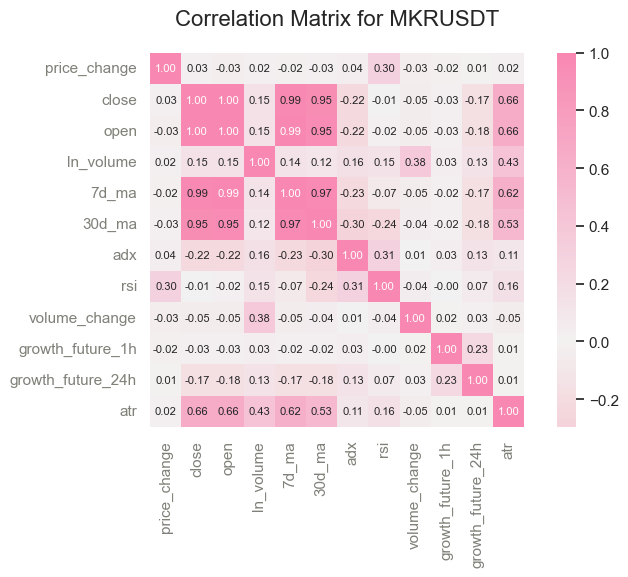

In [15]:
# correlation matrix
sns.set(style="whitegrid")
# calculation
mkr_data = df[df['ticker'] == 'MKRUSDT']
cor_columns = cor_columns = [
    'price_change', 'close', 'open', 'ln_volume', '7d_ma', '30d_ma', 'adx',
    'rsi', 'volume_change', 'growth_future_1h', 'growth_future_24h', 'atr'
]
correlation_matrix_mkr = mkr_data[cor_columns].corr()

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(
  correlation_matrix_mkr,
  annot=True,
  cmap=sns.diverging_palette(h_neg=0, h_pos=350, s=90, l=70, as_cmap=True), 
  center=0,
  fmt='.2f',
  square=True,
  annot_kws={'size': 8}
)
# style
plt.title("Correlation Matrix for MKRUSDT", fontsize=16, pad=20)
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14
ax = plt.gca()
# remove axis frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# colour ticks
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

plt.tight_layout()
# saving
plt.savefig("images/correlation_matrix_mkr.png", dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# Summary of the correlation matrix analysis:
# 1. Strong correlations:
#    - `7d_ma` and `30d_ma` show high correlation with `close` and `open`, indicating their importance for price trends.
#    - `atr` (Average True Range) is moderately correlated with price indicators, highlighting its role in volatility analysis.
# 2. Weak correlations:
#    - Indicators like `adx` and `rsi` show weak correlations with price-related variables but can provide additional signals.
# 3. Volume-related features:
#    - `volume` and `volume_change` exhibit moderate correlations with certain price metrics, making them valuable for demand-supply analysis.
# 4. Growth features:
#    - `growth_future_1h` and `growth_future_24h` have weak correlations with other features, suggesting they could be challenging targets to predict directly.
# 5. Feature importance:
#    - A combination of moving averages (`7d_ma`, `30d_ma`), volatility (`atr`), and volume-based features can provide a strong basis for predicting MKR price trends.


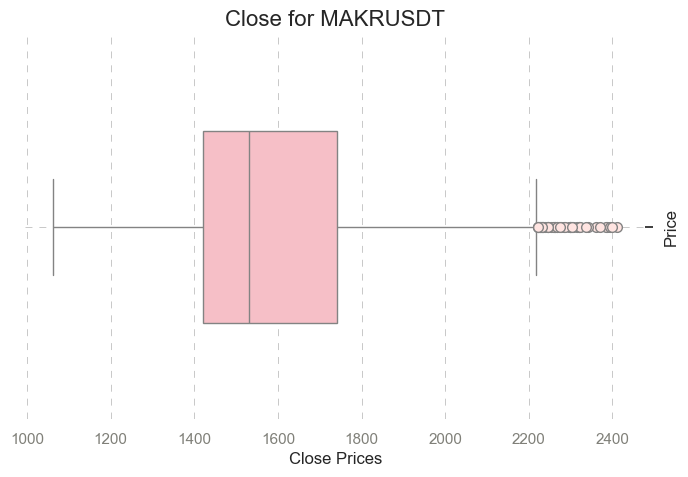

In [17]:
#boxplot
# style
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.boxplot(
    x=mkr_data['close'],
    color='#FFB6C1',
    width=0.5,
    flierprops=dict(markerfacecolor='#FFE4E1', marker='o', markersize=7)
)

# title, axis
plt.title('Close for MAKRUSDT', fontsize=16)
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14
plt.xlabel('Close Prices', fontsize=12)
plt.ylabel('Price', fontsize=12)
ax = plt.gca()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

# remove axis frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# grid
ax.grid(True, color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# ticks, labels
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", left=False, labelleft=False)

# ticks colour
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# save
plt.savefig('images/boxplot_mkr.png', dpi=300, bbox_inches='tight')
plt.show()


In [18]:
# quantile
q1 = mkr_data['close'].quantile(0.25)
q3 = mkr_data['close'].quantile(0.75)
q1, q3

(1422.0, 1741.0)

In [19]:
# Price Analysis for MAKRUSDT:
# - Distribution shows closing prices primarily clustered between 1400-1600 range
# - Box plot indicates median price around 1500
# - Several outliers visible around 2200, suggesting occasional price spikes
# - Data appears to have moderate spread within the core trading range
# - Lower whisker extends to around 1000, indicating historical support level
# - The box (IQR) shows the middle 50% of price activity is relatively concentrated
# - Overall pattern suggests a somewhat stable trading range with occasional upside volatility

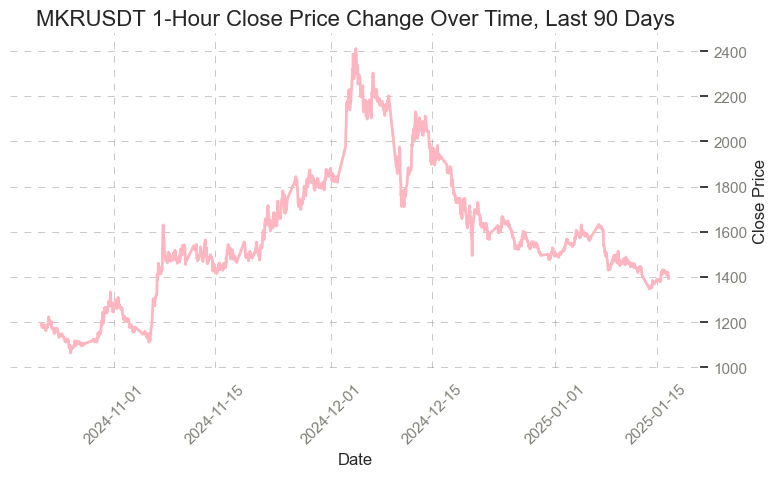

In [20]:
# Converting time
mkr_data = mkr_data.copy()
mkr_data.loc[:, 'date'] = pd.to_datetime(mkr_data['date'], utc=True).dt.tz_convert('Europe/Berlin')
start = (pd.Timestamp.now(tz='Europe/Berlin') - pd.Timedelta(days=90))
end = pd.Timestamp.now(tz='Europe/Berlin')
mkr_data_filtered = mkr_data[(mkr_data['date'] >= start) & (mkr_data['date'] <= end)]

# style
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# plot
plt.plot(mkr_data_filtered['date'], mkr_data_filtered['close'], color='#FFB6C1', linewidth=2)
plt.title('MKRUSDT 1-Hour Close Price Change Over Time, Last 90 Days', fontsize=16)
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)

# axis
ax = plt.gca()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# grid
ax.grid(True, color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# ticker
plt.xticks(rotation=45)
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", left=False, labelleft=False)
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# Saving
plt.tight_layout()
plt.savefig('images/timeseries_mkrusdt.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
# MKRUSDT Price Analysis (90-Day Period):
# - Started around $1200 in mid-October 2024
# - Initial sideways movement until early November
# - Strong upward trend from November to early December
# - Major price spike in early December reaching ~$2400
# - Significant volatility in December with multiple peaks above $2000
# - Gradual downward trend since mid-December
# - Currently showing bearish momentum, trading around $1400
# - Overall range: $1000-2400, with most activity between $1400-2000
# - Pattern suggests a completed pump and distribution phase

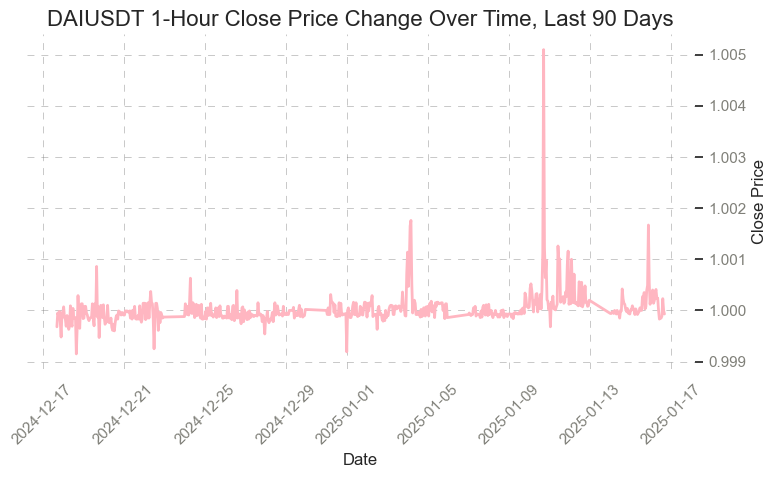

In [22]:
# Converting time
dai_data.loc[:, 'date'] = pd.to_datetime(dai_data['date'], utc=True).dt.tz_convert('Europe/Berlin')
start = (pd.Timestamp.now(tz='Europe/Berlin') - pd.Timedelta(days=90))
end = pd.Timestamp.now(tz='Europe/Berlin')
dai_data_filtered = dai_data[(dai_data['date'] >= start) & (dai_data['date'] <= end)]

# style
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# plot
plt.plot(dai_data_filtered['date'], dai_data_filtered['close'], color='#FFB6C1', linewidth=2)
plt.title('DAIUSDT 1-Hour Close Price Change Over Time, Last 90 Days', fontsize=16)
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)

# axis
ax = plt.gca()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# grid
ax.grid(True, color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# ticker
plt.xticks(rotation=45)
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", left=False, labelleft=False)
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# Saving
plt.tight_layout()
plt.savefig('images/timeseries_daiusd.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
# DAIUSDT Price Analysis (Stablecoin, 90-Day Period):
# - Extremely stable price action around $1.00 as expected for a stablecoin
# - Minimal volatility with most fluctuations staying within $0.999-1.001 range
# - Few notable deviations:
#   * Brief spike to $1.005 around January 9th
#   * Small spike to $1.002 on January 1st
# - Overall maintains excellent peg stability
# - Recent days (Jan 9-13) show slightly increased volatility but still within acceptable ranges
# - Demonstrates proper functioning of DAI's stability mechanisms
# - Trading volume and liquidity appear sufficient to maintain the peg

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


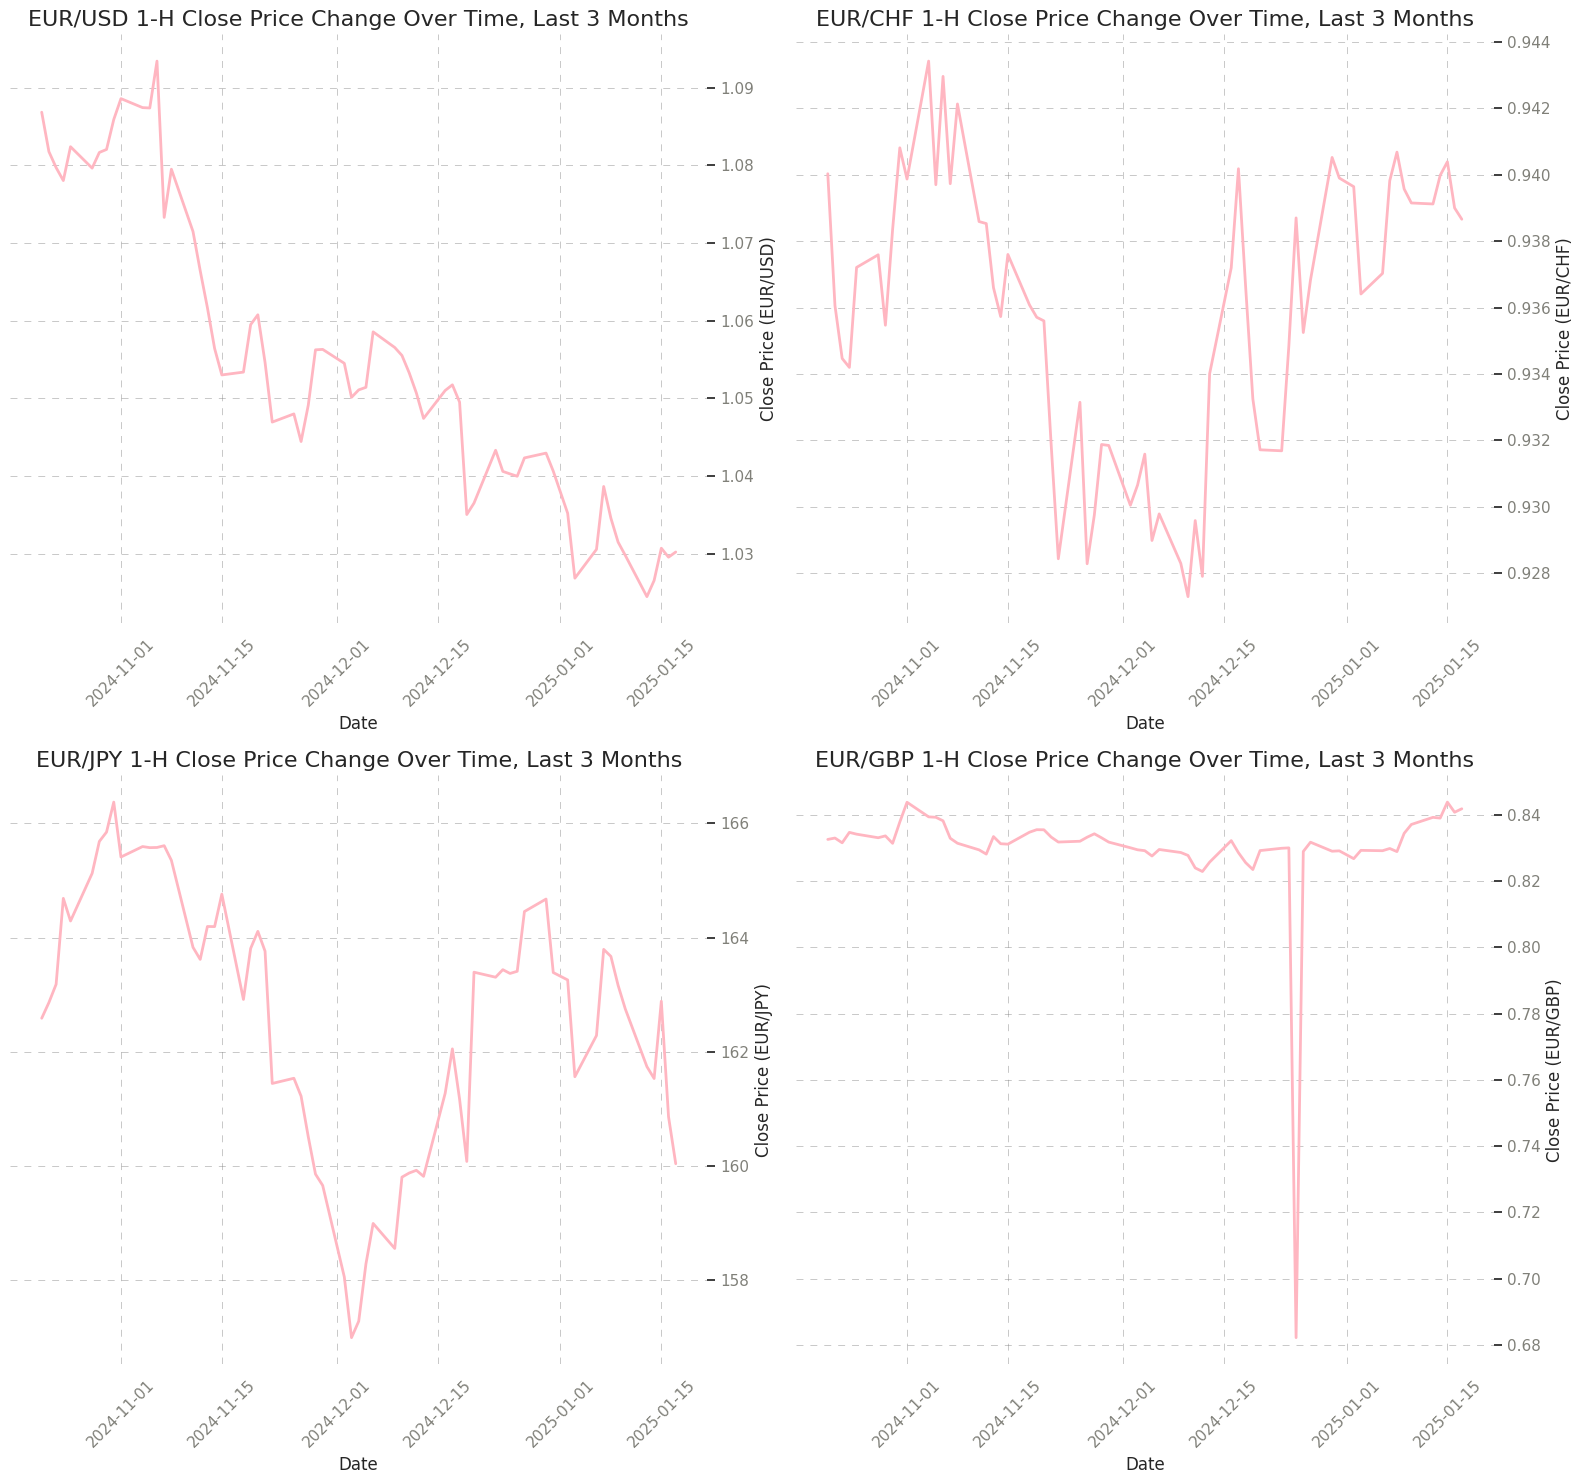

In [24]:
# just for comparision to the stablecoin we are looking at the Euro and its relation with other currencies

# time
start = (pd.Timestamp.now(tz='Europe/Berlin') - pd.Timedelta(days=90))
end = pd.Timestamp.now(tz='Europe/Berlin')

# lists
currency_pairs = ['EURUSD=X', 'EURCHF=X', 'EURJPY=X', 'EURGBP=X']
titles = ['EUR/USD', 'EUR/CHF', 'EUR/JPY', 'EUR/GBP']

# subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 15))  
axs = axs.flatten() 

for i, pair in enumerate(currency_pairs):
    data = yf.download(pair, start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'), interval='1d')
    data.reset_index(inplace=True)
    data['Date'] = pd.to_datetime(data['Date'])

    # plot
    sns.set(style="whitegrid")
    axs[i].plot(data['Date'], data['Close'], color='#FFB6C1', linewidth=2)

    # axis
    axs[i].set_title(f'{titles[i]} 1-H Close Price Change Over Time, Last 3 Months', fontsize=16)
    axs[i].set_xlabel('Date', fontsize=12)
    axs[i].set_ylabel(f'Close Price ({titles[i]})', fontsize=12)

    axs[i].tick_params(axis="x", colors="black")
    axs[i].tick_params(axis="y", left=True, labelleft=True)
    axs[i].yaxis.tick_right()
    axs[i].yaxis.set_label_position("right")
    axs[i].tick_params(axis="x", rotation=45)

    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)

    axs[i].grid(True, color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

    # ticks
    [t.set_color('#808079') for t in axs[i].yaxis.get_ticklabels()]
    [t.set_color('#808079') for t in axs[i].xaxis.get_ticklabels()]

# saving
plt.tight_layout()
plt.savefig('images/timeseries_eur.png', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
print(mkr_data['date'].head())
print(mkr_data['date'].dtype)


29793    2024-10-18 17:00:00+02:00
29794    2024-10-18 18:00:00+02:00
29795    2024-10-18 19:00:00+02:00
29796    2024-10-18 20:00:00+02:00
29797    2024-10-18 21:00:00+02:00
Name: date, dtype: object
object


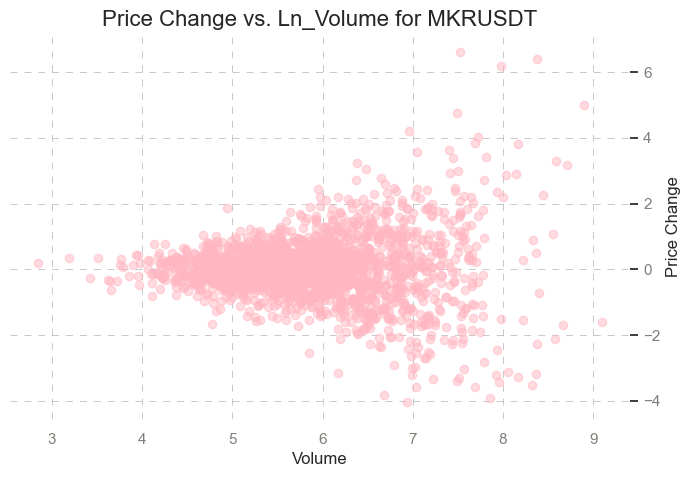

In [26]:
# scatterplot
# style
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
plt.scatter(
    mkr_data['ln_volume'], 
    mkr_data['price_change'],
    color='#FFB6C1',  # Light Pink
                      # '#FFC0CB' (Pink)
                      # '#FFE4E1' (Misty Rose)
                      # '#FDD7E4' (Zarter Rosa)
                      # '#F8B3D9' (Helles Pink)
    alpha=0.5
)

plt.title('Price Change vs. Ln_Volume for MKRUSDT', fontsize=16)
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14
plt.xlabel('Volume', fontsize=12)
plt.ylabel('Price Change', fontsize=12)

# axis
ax = plt.gca()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# grid
ax.grid(True, axis='both', color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# ticks, labels
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", left=False, labelleft=False)
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# saving
plt.savefig('images/price_change_correlation_with_volume.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
# This scatter plot visualizes the relationship between trading volume and price change for the MKR/USDT pair.
# Observations:
# - Most trading activity clusters between volumes 4-8 with price changes between -2 to +2
# - Higher volumes (>6) show increased price volatility with changes up to ±6
# - The spread pattern suggests higher trading volumes correlate with higher price volatility
# - The distribution is relatively symmetric around 0, indicating no strong directional bias
# - Lower volumes (<5) show more contained price movements, suggesting more stable pricing during lower activity periods

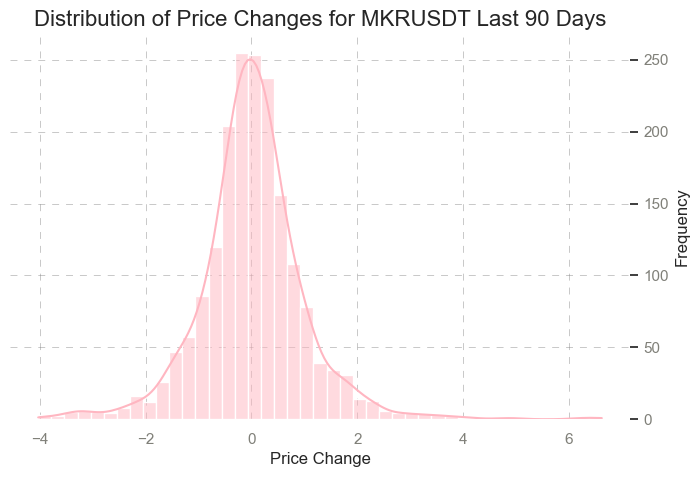

In [28]:
# histrogram
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
# optimal bin
n = len(mkr_data)
bins = int(np.sqrt(n))

# plot
sns.histplot(
    mkr_data['price_change'], 
    bins=bins, 
    kde=True,
    color='#FFB6C1' 
)

plt.title('Distribution of Price Changes for MKRUSDT Last 90 Days', fontsize=16)
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14
plt.xlabel('Price Change', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# axis
ax = plt.gca()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# grid
ax.grid(True, axis='both', color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# ticks, labels
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", left=False, labelleft=False)
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# saving
plt.savefig('images/distribution_price_change.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
# MKRUSDT Price Change Distribution Analysis:
# - Distribution appears approximately normal (bell-shaped)
# - Centered around 0, indicating balanced price movements
# - Most frequent changes are small (between -1 and +1)
# - Slight negative skew visible
# - Few extreme outliers, especially on positive side (up to +6)
# - Distribution tails extend from roughly -4 to +6
# - Peak frequency around 250 occurrences for smallest changes

# Standard Deviation, Mean Reversion Indikatoren, Volume Profile (wegen der klaren Preisverteilung), ATR, Bollinger Bands, RSI, MACD, Keltner Channels oder Bollinger Bands

In [30]:
for col in df.columns:
    print(f"Column: {col}")
    print(f"Type: {df[col].dtype}")
    print(f"Data: {df[col].head(5).tolist()}")
    print("-" * 40)

Column: date
Type: object
Data: ['2024-10-21 15:30:00+02:00', '2024-10-21 16:30:00+02:00', '2024-10-21 17:30:00+02:00', '2024-10-21 18:30:00+02:00', '2024-10-21 19:30:00+02:00']
----------------------------------------
Column: year
Type: int64
Data: [2024, 2024, 2024, 2024, 2024]
----------------------------------------
Column: month
Type: int64
Data: [10, 10, 10, 10, 10]
----------------------------------------
Column: day
Type: int64
Data: [21, 21, 21, 21, 21]
----------------------------------------
Column: hour
Type: int64
Data: [15, 16, 17, 18, 19]
----------------------------------------
Column: ticker
Type: category
Data: ['^SPX', '^SPX', '^SPX', '^SPX', '^SPX']
----------------------------------------
Column: ticker_type
Type: category
Data: ['indices', 'indices', 'indices', 'indices', 'indices']
----------------------------------------
Column: open
Type: float64
Data: [5857.81982421875, 5857.7998046875, 5826.43017578125, 5840.31982421875, 5847.60009765625]
--------------------

In [31]:
non_numeric_columns = df.select_dtypes(exclude=["number"]).columns
print("Non Numeric Columns:", non_numeric_columns.tolist())

Non Numeric Columns: ['date', 'ticker', 'ticker_type']


In [32]:
missing_values = df[['ticker', 'ticker_type']].isnull().sum()
missing_values 

ticker         0
ticker_type    0
dtype: int64

In [7]:
# checking if there are infinity data and replace with nan
infinity_check = df.replace([np.inf, -np.inf], np.nan).isnull().sum()

# print columns that have infinity
print("Columns with infinity:")
print(infinity_check[infinity_check > 0])

Columns with infinity:
7d_ma                     6
30d_ma                   29
7d_volatility             6
sma10                     9
sma20                    19
volume_change          4578
close_lag_1               1
adx                      27
aroon                    14
cci                      13
cmo                      14
macd                     33
macd_signal              33
macd_hist                33
mom                      10
ppo                      25
roc                      10
rsi                      14
willr                    13
atr                      14
trix                     88
kama                     30
growth_1h                39
growth_future_1h         39
growth_4h               156
growth_future_4h        156
growth_24h              936
growth_future_24h       936
growth_48h             1872
growth_future_48h      1872
growth_72h             2808
growth_future_72h      2808
growth_168h            6552
growth_future_168h     6552
growth_336h           131

In [8]:
# checking for ticker where volume is 0
zero_volume_tickers = df[df['ln_volume'] == 0]['ticker']
print(zero_volume_tickers)

0          ^SPX
35         ^SPX
70         ^SPX
98         ^SPX
105        ^SPX
          ...  
46345    DAIEUR
46346    DAIEUR
46347    DAIEUR
46350    DAIEUR
46351    DAIEUR
Name: ticker, Length: 4577, dtype: category
Categories (39, object): ['AAVEUSDT', 'ADAUSDT', 'BITF', 'BITO', ..., '^IXIC', '^N225', '^SPX', '^VIX']


In [9]:
# new csv
df.to_csv('db/one_df.csv', index=False)

# 4. Maschine Learning

## 4.1 Preparation

In [10]:
# dropping date
if 'date' in df.columns:
    df.drop(columns=['date'], inplace=True)

df = df.fillna(df.select_dtypes(include=['number']).mean())

# splitting
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# y percentage close
y_train = ((df_train['close'] - df_train['close_lag_1']) / df_train['close_lag_1']).values
y_val = ((df_val['close'] - df_val['close_lag_1']) / df_val['close_lag_1']).values
y_test = ((df_test['close'] - df_test['close_lag_1']) / df_test['close_lag_1']).values

df_full_train = df_full_train.reset_index(drop=True)

df_full_train.close.value_counts(normalize=True)

df_full_train.close.mean()

# del what we want to predict
del df_train['close_lag_1']
del df_val['close_lag_1']
del df_test['close_lag_1']

del df_train['close']
del df_val['close']
del df_test['close']

In [19]:
# looking at , because rmse is using this value
mean_y = np.mean(y_val) 
std_y = np.std(y_val)    

print(f"Mittelwert von y: {mean_y:.4f}")
print(f"Standardabweichung von y: {std_y:.4f}")

Mittelwert von y: 0.0557
Standardabweichung von y: 5.3460


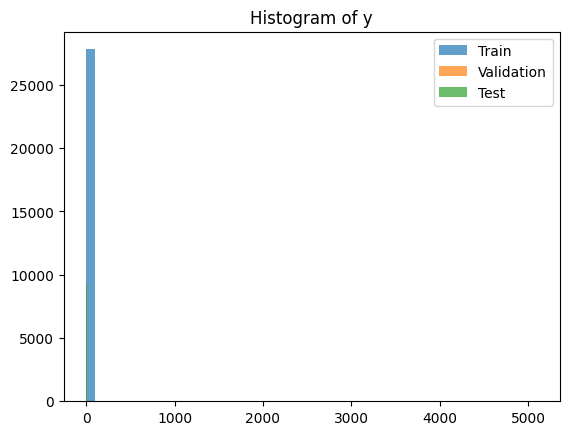

/var/folders/_4/617xrc517f5dk8c2t0gbnksr0000gn/T/ipykernel_78146/1353037399.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([y_train, y_val, y_test], labels=["Train", "Validation", "Test"])


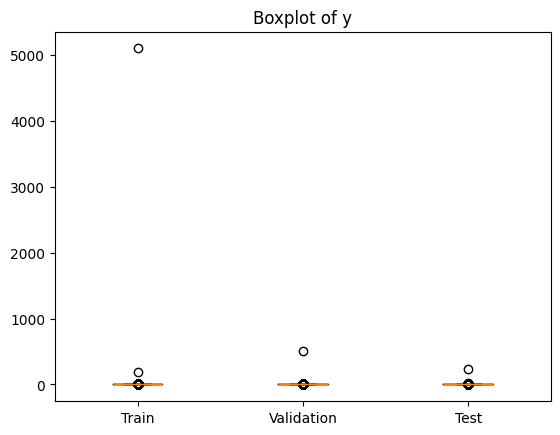

In [24]:
import matplotlib.pyplot as plt

# Histogramm
plt.hist(y_train, bins=50, alpha=0.7, label="Train")
plt.hist(y_val, bins=50, alpha=0.7, label="Validation")
plt.hist(y_test, bins=50, alpha=0.7, label="Test")
plt.legend()
plt.title("Histogram of y")
plt.show()

# Boxplot
plt.boxplot([y_train, y_val, y_test], labels=["Train", "Validation", "Test"])
plt.title("Boxplot of y")
plt.show()


In [ ]:
# Histogram of y (Top)
# Description:
# The histogram shows the frequency distribution of the target variable y across the three datasets: Train, Validation, and Test.
# Observation:
# Most values are concentrated close to 0.
# However, there are some extreme outliers above 5000.
# The distribution is highly skewed, with almost all values clustered in a very small range, while a few values are very far apart.
# Interpretation:
# Such extreme outliers can negatively impact the model, as they increase the error and "confuse" the model.
# The skewed distribution might also indicate that the model will struggle to predict y correctly.

# Boxplot of y (Bottom)
# Description:
# The boxplot shows the distribution of y (Train, Validation, Test) and highlights outliers.
# Observation:
# The box (Interquartile Range, IQR) is very small, indicating that most of the data points are very close to each other.
# There are many strong outliers, exceeding 1000.
# This is consistent with the histogram: most values are small, but a few values are extremely large.
# Interpretation:
# The outliers can significantly impact the training and validation process of the model, as they distort the MSE and RMSE.
# You should identify the outliers and decide whether to remove or transform them (see below).


In [25]:
#creating log as data has extreme outliers and is skewed
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)

In [11]:
numerical = ['open', 'high', 'low', 'ln_volume', 'volume_change', 'price_change',
             'growth_4h', 'growth_24h', 'growth_48h', 'growth_72h',
             'growth_168h', 'growth_336h', 'growth_720h']

categorical = ['year', 'month', 'day', 'hour', 'ticker', 'ticker_type']

technical = ['adx', 'aroon', 'bop', 'cci', 'cmo', 'macd', 'macd_signal', 'macd_hist',
            'mom', 'ppo', 'roc', 'rsi', 'willr', 'atr', 'trix', 'kama',
            '7d_ma', '30d_ma', '7d_volatility', 'intraday_range', 'fibonacci_0',
            'fibonacci_23_6', 'fibonacci_38_2', 'fibonacci_50', 'fibonacci_61_8',
            'fibonacci_100', 'sma10', 'sma20']

growth_future = ['growth_future_4h','is_positive_growth_24h_future', 'is_positive_growth_48h_future',
            'is_positive_growth_72h_future', 'is_positive_growth_168h_future',
            'is_positive_growth_336h_future', 'is_positive_growth_720h_future']


In [12]:
X_train = df_train
X_val = df_val
X_test = df_test

# one hot encoding
dv = DictVectorizer(sparse=False)
train_dict = df_train[categorical + numerical + technical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical + technical].to_dict(orient='records')
X_val = dv.transform(val_dict)

# transforming test data
test_dict = df_test[categorical + numerical + technical].to_dict(orient='records')
X_test = dv.transform(test_dict)


In [13]:
# scaling df
scaler = StandardScaler()
numerical_features = numerical + technical

# fitting scaler
X_train_num = scaler.fit_transform(X_train[:, :len(numerical_features)])
X_val_num = scaler.transform(X_val[:, :len(numerical_features)])
X_test_num = scaler.transform(X_test[:, :len(numerical_features)])

# combining it with categorical
X_train = np.hstack([X_train_num, X_train[:, len(numerical_features):]])
X_val = np.hstack([X_val_num, X_val[:, len(numerical_features):]])
X_test = np.hstack([X_test_num, X_test[:, len(numerical_features):]])


## 4.2 Linear Regression

In [28]:
# model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train_log)

# pred
y_pred_val_lr = model_lr.predict(X_val)

# evaluation
mse_val_lr = mean_squared_error(np.expm1(y_val_log), y_pred_val_lr) 
r2_val_lr = r2_score(np.expm1(y_val_log), y_pred_val_lr)

print(f"Linear Regression Mean Squared Error on Validation-Set: {mse_val_lr:.2f}")
print(f"Linear Regression R² on Validation-Set: {r2_val_lr:.2f}")

# pred for test set
y_pred_test_log = model_lr.predict(X_test)
y_pred_test = np.expm1(y_pred_test_log)

# evaluation for test set
mse_test_lr = mean_squared_error(np.expm1(y_test_log), y_pred_test)
r2_test_lr = r2_score(np.expm1(y_test_log), y_pred_test)

print(f"Mean Squared Error on Test-Set: {mse_test_lr:.2f}")
print(f"R² on Test-Set: {r2_test_lr:.2f}")

# mse
mse_val_original = mean_squared_error(np.expm1(y_val_log), model_lr.predict(X_val))
print(f"Original Mean Squared Error: {mse_val_original:.2f}")

# saving results
feature_accuracies = {}
feature_names = dv.get_feature_names_out()

# loop for features
for feature_idx in range(X_train.shape[1]):
    X_train_reduced = X_train[:, [i for i in range(X_train.shape[1]) if i != feature_idx]]
    X_val_reduced = X_val[:, [i for i in range(X_val.shape[1]) if i != feature_idx]]

    # model
    model_lr_reduced = LinearRegression()
    model_lr_reduced.fit(X_train_reduced, y_train_log)
  

    # new mse
    mse_reduced = mean_squared_error(np.expm1(y_val_log), model_lr_reduced.predict(X_val_reduced))
    mse_difference = mse_val_original - mse_reduced

    # features with mse
    feature_accuracies[feature_names[feature_idx]] = mse_difference

# print features
for feature_name, mse_diff in feature_accuracies.items():
    print(f"Feature: {feature_name}, MSE Difference: {mse_diff:.4f}")

# extracting important ones
important_features = [feature for feature, diff in feature_accuracies.items() if diff != 0.0]
print("Important Features:", important_features)

# new set
X_train_reduced = X_train[:, [feature_names.tolist().index(feature) for feature in important_features]]
X_val_reduced = X_val[:, [feature_names.tolist().index(feature) for feature in important_features]]
X_test_reduced = X_test[:, [feature_names.tolist().index(feature) for feature in important_features]]

# model with reduced features
model_lr_reduced = LinearRegression()
model_lr_reduced.fit(X_train_reduced, y_train_log)

# pred for red
y_pred_val_reduced = model_lr_reduced.predict(X_val_reduced)

# mse root2
mse_val_reduced = mean_squared_error(np.expm1(y_val_log), y_pred_val_reduced)
r2_val_reduced = r2_score(np.expm1(y_val_log), y_pred_val_reduced)

print(f"Mean Squared Error on reduced Validation-Set: {mse_val_reduced:.2f}")
print(f"R² on reduced Validation-Set: {r2_val_reduced:.2f}")

# pred red tst set
y_pred_test_reduced = model_lr_reduced.predict(X_test_reduced)

# mse root2 test set
mse_test_reduced = mean_squared_error(np.expm1(y_test_log), y_pred_test_reduced)
r2_test_reduced = r2_score(np.expm1(y_test_log), y_pred_test_reduced)

print(f"Mean Squared Error on Test-Set: {mse_test_reduced:.2f}")
print(f"R² on Test-Set: {r2_test_reduced:.2f}")

Linear Regression Mean Squared Error on Validation-Set: 28.51
Linear Regression R² on Validation-Set: 0.00
Mean Squared Error on Test-Set: 6.20
R² on Test-Set: -0.01
Original Mean Squared Error: 28.51
Feature: 30d_ma, MSE Difference: -0.0025
Feature: 7d_ma, MSE Difference: -0.0017
Feature: 7d_volatility, MSE Difference: 0.0008
Feature: adx, MSE Difference: 0.0000
Feature: aroon, MSE Difference: -0.0001
Feature: atr, MSE Difference: 0.0011
Feature: bop, MSE Difference: -0.0002
Feature: cci, MSE Difference: -0.0066
Feature: cmo, MSE Difference: -0.0000
Feature: day, MSE Difference: 0.0000
Feature: fibonacci_0, MSE Difference: -0.0004
Feature: fibonacci_100, MSE Difference: 0.0000
Feature: fibonacci_23_6, MSE Difference: 0.0000
Feature: fibonacci_38_2, MSE Difference: 0.0000
Feature: fibonacci_50, MSE Difference: 0.0000
Feature: fibonacci_61_8, MSE Difference: 0.0000
Feature: growth_168h, MSE Difference: 0.0000
Feature: growth_24h, MSE Difference: 0.0002
Feature: growth_336h, MSE Differen

In [44]:
# The Linear Regression model shows a Mean Squared Error (MSE) of 28.51 on the validation set, 
# indicating a moderate level of prediction error. An R² of 0.00 suggests that the model does 
# not explain any variance in the data, meaning it is not capturing meaningful patterns.

# On the test set, the MSE is 6.20, which is slightly better than the validation set, but 
# the R² of -0.01 indicates that the model performs poorly and does not generalize well.

# After reducing the feature set, the model still shows an MSE of 28.51 on the validation set, 
# indicating no improvement in performance from feature reduction. The R² remains at 0.00, showing 
# that the reduced feature set does not help in improving model fit.

# On the test set, the reduced model's MSE improves slightly to 6.09, and the R² increases slightly 
# to 0.01, suggesting a very marginal improvement in prediction accuracy.

# Conclusion:
# - The model is not performing well, with low R² values across both validation and test sets, 
# indicating it does not explain the target variable's variance.
# - Further model tuning, feature engineering, or alternative modeling approaches may be required 
# to improve predictive performance.


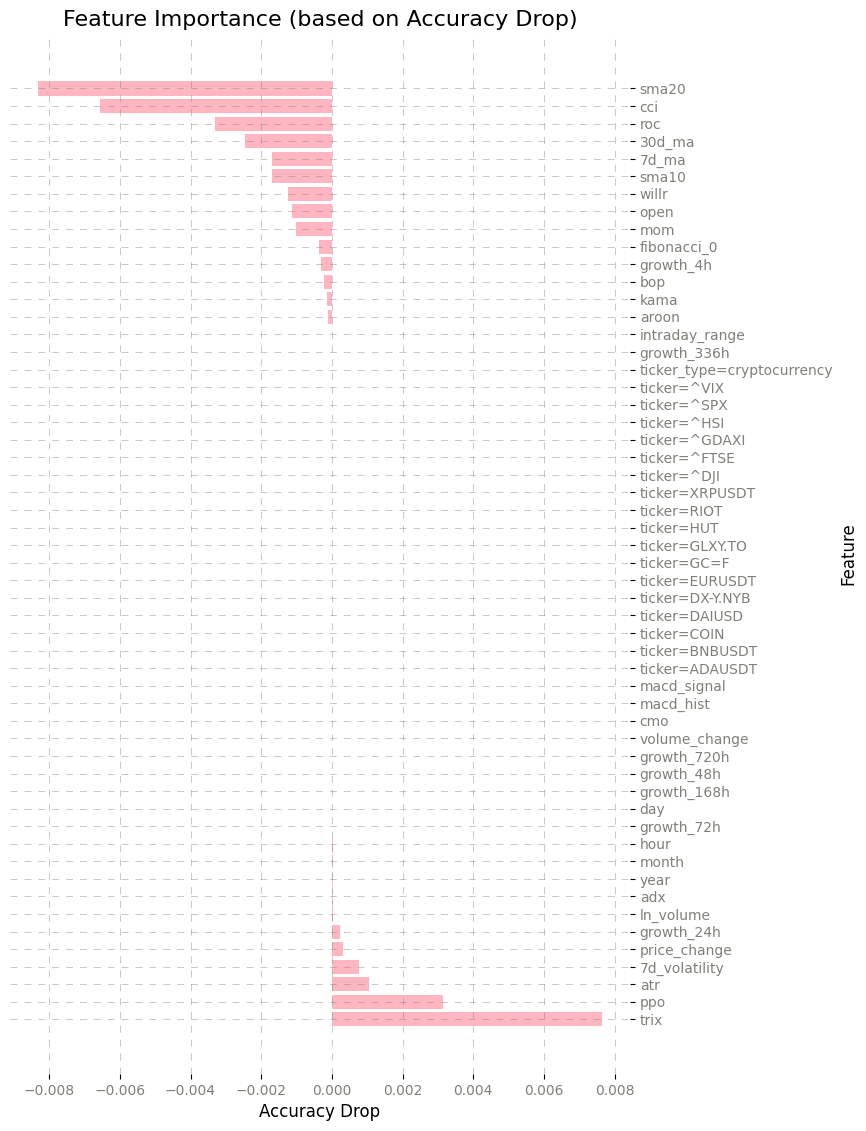

In [29]:
# filter out features with 0 impact
filtered_features = {k: v for k, v in feature_accuracies.items() if v != 0.0}

# sort remaining features
sorted_features = sorted(filtered_features.items(), key=lambda x: x[1], reverse=True)
features, importance = zip(*sorted_features)

# plot updated chart
plt.figure(figsize=(8, len(features) * 0.25))  
plt.barh(features, importance, color='#FFB6C1')

plt.title('Feature Importance (based on Accuracy Drop)', fontsize=16)
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14
plt.xlabel('Accuracy Drop', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# axis
ax = plt.gca()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# grid
ax.grid(True, axis='both', color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# ticks, labels
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", left=False, labelleft=False)
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# saving
plt.savefig('images/feature_importance_on_accuracy_drop.png', dpi=300, bbox_inches='tight')
plt.show()

In [46]:
# Feature Importance Analysis:

# Features like 'trix' and 'ppo' show positive accuracy drop, meaning removing these features decreases model accuracy
# These are important features that contribute positively to the model's performance

# Features like 'sma20', 'cci', and 'roc' show negative accuracy drop, meaning removing these features could improves model accuracy
# These features might introduce noise or redundant information
# Could indicate potential overfitting when these features are included

# Key observations:
# Most technical indicators (e.g., moving averages, oscillators) have minimal impact
# The strongest positive contributors are trend indicators (trix, ppo)
# Some common technical indicators (sma20, cci) might be detrimental to model performance
# Many features show negligible impact (near zero), suggesting they could be removed
# to simplify the model without significant performance loss

Mean Squared Error (MSE): 28.49
Mean Absolute Error (MAE): 0.07
R-squared (R²): 0.00


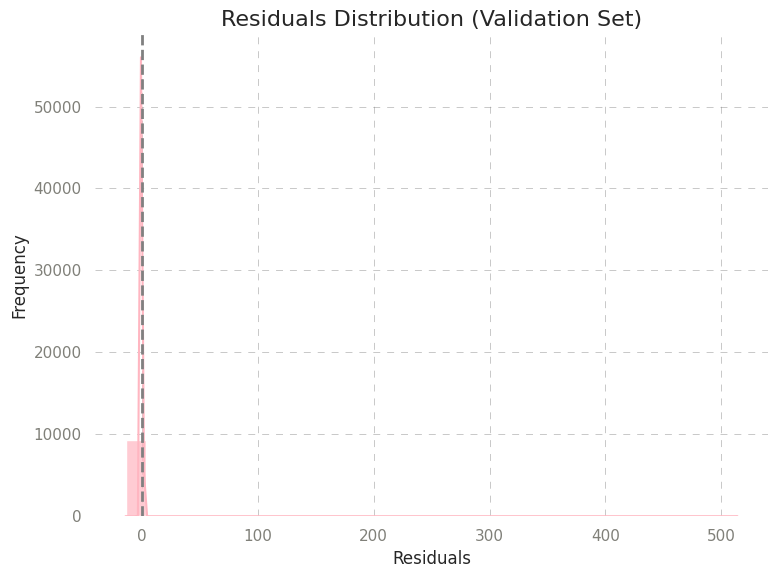

In [33]:
# style
sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 14

# get predictions
y_pred_log = model_lr.predict(X_val)
y_pred = np.expm1(y_pred_log)  

# calculate regression metrics on transformed data
mse = mean_squared_error(np.expm1(y_val_log), y_pred) 
mae = mean_absolute_error(np.expm1(y_val_log), y_pred)
r2 = r2_score(np.expm1(y_val_log), y_pred)

# print
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")

# plot residuals
residuals = np.expm1(y_val_log) - y_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='#FFB6C1', bins=30, alpha=0.7)
plt.axvline(0, color='gray', linestyle='--', linewidth=2)

# Title and labels
plt.title('Residuals Distribution (Validation Set)', fontsize=16)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Style the plot
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Grid styling
ax.grid(True, axis='both', color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# Tick styling
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", colors="black")
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# Layout and save
plt.tight_layout()
plt.savefig('images/residuals_distribution_lr.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# MSE (28.49): Relatively high mean squared error indicates significant prediction deviations, model has room for improvement in accuracy

# MAE (0.07): Low mean absolute error suggests predictions are reasonably close to actual values, indicates better performance than MSE might suggest

# R-squared (0.00): Zero R-squared indicates the model explains none of the variability
# Model performs no better than a horizontal line at the mean, major concern about model's predictive capabilities

# Distribution characteristics:
# Extremely right-skewed distribution
# High concentration of residuals near zero (shown by tall peak)
# Long tail extending to positive values
# Non-normal distribution pattern
# Potential outliers in the positive direction

# Model assessment:
# The model tends to underpredict values (positive residuals)
# Not an ideal residual distribution for a linear regression
# Suggests underlying assumptions of linear regression might be violated

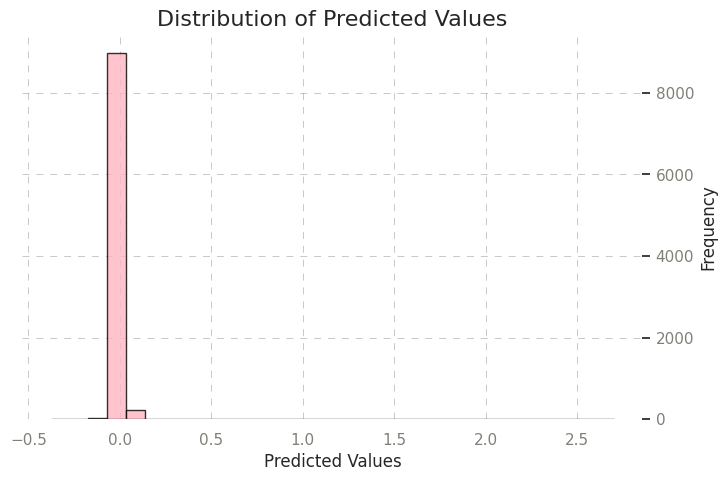

In [32]:
# histogram of predictions
plt.figure(figsize=(8, 5))
plt.hist(y_pred, bins=30, alpha=0.8, color='#FFB6C1' , edgecolor="black")
plt.title("Distribution of Predicted Values", fontsize=16)
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# axis
ax = plt.gca()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# ticks, labels
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", left=False, labelleft=False)
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# grid
ax.grid(True, axis='both', color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# saving
plt.savefig('images/predicted_values_distribution_lr.png', dpi=300, bbox_inches='tight')
plt.show()

In [49]:
# The histogram shows the distribution of predicted values. 
# Most predictions are centered around 0, with a sharp peak and minimal spread. 
# This indicates that the model is predicting a narrow range of values, 
# which could suggest underfitting or that the target variable has a limited variance.
# Further investigation might be necessary to evaluate the input features 
# and whether they capture sufficient variability to improve predictions.


## 4.3 Decision Tree

In [54]:
# lists for tuning parameters
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]
sample_leafs = [1, 5, 10, 15, 20, 50, 100, 200]

# tuning max_depth
print("Tuning max_depth for Decision Tree Regressor:")
for depth in depths:
    dt = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)

    # predicting for evaluation
    y_pred = dt.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    print(f"max_depth = {depth} -> MSE: {mse:.3f}")

# tuning max_depth and min_samples_leaf
print("\nTuning max_depth and min_samples_leaf for Decision Tree Regressor:")
scores = []

for depth in depths:
    for s in sample_leafs:
        dt = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=s, random_state=42)
        dt.fit(X_train, y_train)

        # Predicting for evaluation
        y_pred = dt.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        scores.append((depth, s, mse))

# convert to df
columns = ['max_depth', 'min_samples_leaf', 'mse']
df_scores = pd.DataFrame(scores, columns=columns)

# visualize
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns='max_depth', values='mse')
print("\nTuning Results (MSE):")
print(df_scores_pivot.round(3))

# select best model (with lowest MSE)
best_params = df_scores.loc[df_scores['mse'].idxmin()]
print("\nBest Hyperparameters:")
print(best_params)

# final model with best parameters
model_dt = DecisionTreeRegressor(max_depth=int(best_params['max_depth']),
                                  min_samples_leaf=int(best_params['min_samples_leaf']),
                                  random_state=42)
model_dt.fit(X_train, y_train)

# predicting for the validation set
y_pred_val_dt = model_dt.predict(X_val)

# evaluation
print(f"Decision Tree Regressor MSE on the validation set: {mean_squared_error(y_val, y_pred_val_dt):.3f}")
print(f"Decision Tree Regressor R2 Score on the validation set: {r2_score(y_val, y_pred_val_dt):.3f}")


Tuning max_depth for Decision Tree Regressor:
max_depth = 1 -> MSE: 2843.851
max_depth = 2 -> MSE: 3169.903
max_depth = 3 -> MSE: 3169.903
max_depth = 4 -> MSE: 3169.902
max_depth = 5 -> MSE: 2568.696
max_depth = 6 -> MSE: 2568.695
max_depth = 10 -> MSE: 3169.903
max_depth = 15 -> MSE: 2568.695
max_depth = 20 -> MSE: 2568.696
max_depth = None -> MSE: 2568.695

Tuning max_depth and min_samples_leaf for Decision Tree Regressor:

Tuning Results (MSE):
max_depth             NaN       1.0       2.0       3.0       4.0       5.0   \
min_samples_leaf                                                               
1                 2568.695  2843.851  3169.903  3169.903  3169.902  2568.696   
5                 2972.633  2972.632  2972.632  2972.633  2972.633  2972.633   
10                3054.712  3054.712  3054.712  3054.712  3054.712  3054.712   
15                3079.935  3079.935  3079.935  3079.935  3079.935  3079.935   
20                3094.360  3094.360  3094.360  3094.360  3094.360 

In [ ]:
# The model's MSE is relatively low (~2568), but the R² score of 0.181 indicates poor generalization.
# This suggests underfitting, meaning the model isn't capturing enough variance in the data.
# Consider exploring more complex models (e.g., Random Forest, Gradient Boosting) or improving feature engineering.


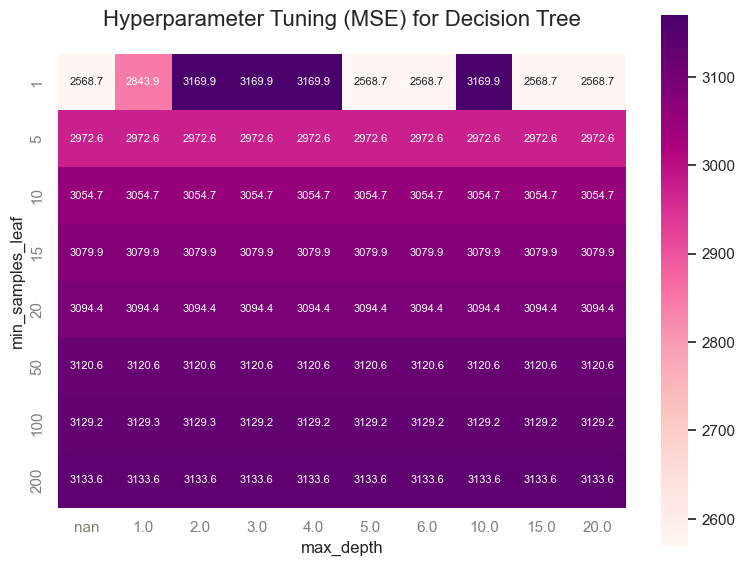

In [56]:
# heatmap
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.heatmap(
    df_scores_pivot,
    annot=True,
    fmt=".1f",
    cmap=sns.color_palette("RdPu", as_cmap=True),  # Einzelne Farbrichtung statt divergierend
    square=True,
    annot_kws={'size': 8}
)

# title
plt.title('Hyperparameter Tuning (MSE) for Decision Tree', fontsize=16, pad=20)
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14

# axis
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# ticks
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]
plt.tight_layout()

# save
plt.savefig('images/heatmap_dt.png', dpi=300, bbox_inches='tight')
plt.show()

In [46]:
# Heatmap Interpretation:
# MSE values range from ~2600 to ~3130, showing meaningful variation in model performance
# Lower MSE values (lighter colors) indicate better model performance
# Best performance achieved with min_samples_leaf=1 and varying max_depth values

# Impact of min_samples_leaf:
# Small min_samples_leaf values (1-5) generally perform better, Sweet spot min_samples_leaf=1
# Performance consistently degrades as min_samples_leaf increases
# Highest MSE values observed with min_samples_leaf >= 100


# Impact of max_depth:
# Less significant impact compared to min_samples_leaf
# For min_samples_leaf=1, optimal max_depth values are around 1.0-4.0
# Beyond max_depth=4.0, no significant improvement in performance
# Model shows stability across different max_depth values for larger min_samples_leaf

# Key Findings:
# Optimal configuration: min_samples_leaf=1 with max_depth between 1.0-4.0
# Best MSE: ~2568.7 (lightest color in heatmap)
# More complex trees (higher max_depth) don't necessarily improve performance
# Increasing min_samples_leaf consistently leads to worse performance

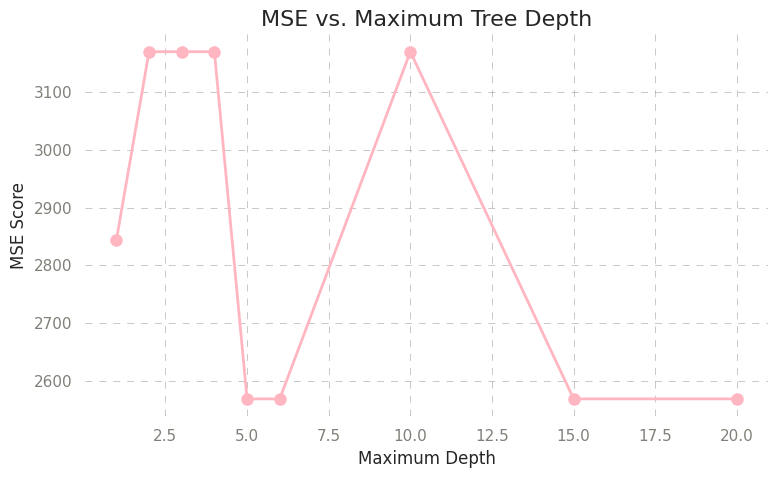


Best max_depth: 15
Best MSE Score: 2568.695


In [57]:
# plot
sns.set(style="whitegrid")
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14
plt.figure(figsize=(8, 5))

# calculate R^2 scores for different depths
r2_scores = [
    mean_squared_error(
        y_val, 
        DecisionTreeRegressor(
            max_depth=depth, 
            random_state=42
        ).fit(X_train, y_train).predict(X_val)
    ) 
    for depth in depths
]

# create line plot
plt.plot(depths, r2_scores, marker='o', color='#FFB6C1', linewidth=2, markersize=8)

# title and labels
plt.title('MSE vs. Maximum Tree Depth', fontsize=16)
plt.xlabel('Maximum Depth', fontsize=12)
plt.ylabel('MSE Score', fontsize=12)

# axis
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# grid
ax.grid(True, axis='both', color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# ticks
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", colors="black")
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# save
plt.tight_layout()
plt.savefig('images/mse_vs_max_depth_dt.png', dpi=300, bbox_inches='tight')
plt.show()

# print best depth
best_depth = depths[np.argmin(r2_scores)]
print(f"\nBest max_depth: {best_depth}")
print(f"Best MSE Score: {min(r2_scores):.3f}")


In [ ]:
# Optimal max_depth found at 15 with lowest MSE of 2568.695
# High MSE plateau around depth 2.5-3.5 (~3150)
# Sharp performance improvement between depth 3.5-5
# Significant MSE spike at depth 10
# Stabilizes after depth 15 with no further improvements



Best Configuration:
max_depth: 4.0
min_samples_leaf: 13.0
Cross-Validation MSE: 12.9


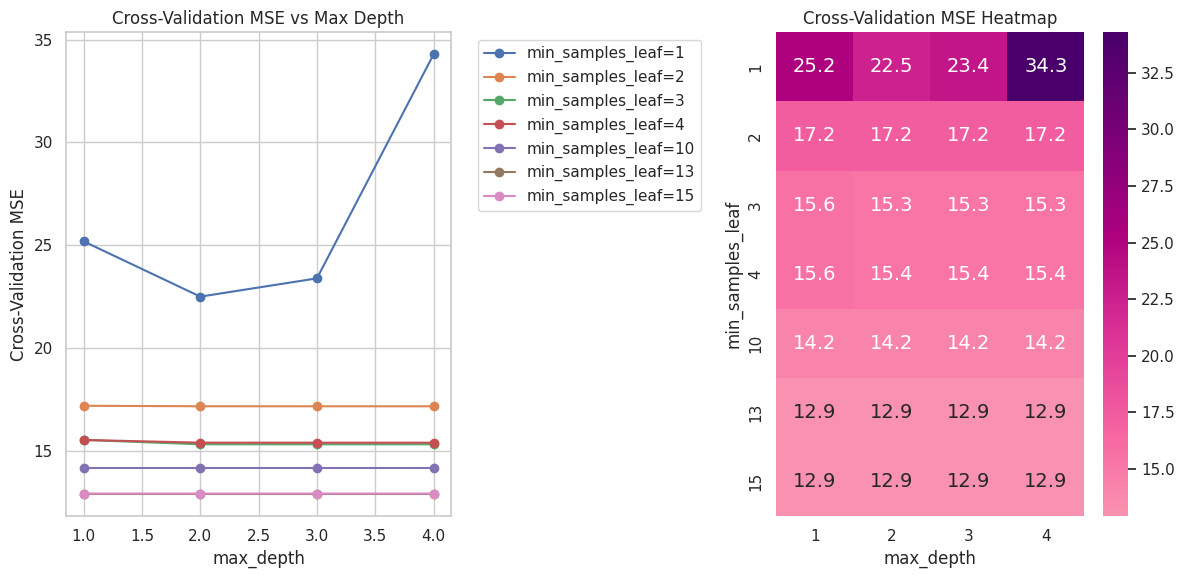

In [59]:
# now lets do 5-folds cross validation to get more robust results
# hyperparameter ranges 
max_depths = [1, 2, 3, 4]  
min_samples_leafs = [1, 2, 3, 4, 10, 13, 15] 

def validate_hyperparameters_with_cv(X, y):
    # Store results
    results = []
    
    # test all combinations
    for depth in max_depths:
        for samples in min_samples_leafs:
            # initialize model with hyperparameters
            model = DecisionTreeRegressor(
                max_depth=depth,
                min_samples_leaf=samples,
                random_state=42
            )
            
            # Perform cross-validation and calculate the negative mean squared error
            cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
            
            # calculate the mean of the negative mse
            mean_val_mse = -cv_scores.mean()
            
            results.append({
                'max_depth': depth,
                'min_samples_leaf': samples,
                'cv_val_mse': mean_val_mse
            })
    
    return pd.DataFrame(results)

# run validation with cross-validation
results_df = validate_hyperparameters_with_cv(X_train, y_train)

# create visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for samples in min_samples_leafs:
    mask = results_df['min_samples_leaf'] == samples
    plt.plot(
        results_df[mask]['max_depth'],
        results_df[mask]['cv_val_mse'],
        'o-',
        label=f'min_samples_leaf={samples}'
    )

plt.title('Cross-Validation MSE vs Max Depth')
plt.xlabel('max_depth')
plt.ylabel('Cross-Validation MSE')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# heatmap of cross-validation results
plt.subplot(1, 2, 2)
pivot_results = results_df.pivot(
    index='min_samples_leaf',
    columns='max_depth',
    values='cv_val_mse'
)

sns.heatmap(
    pivot_results,
    annot=True,
    fmt='.1f',
    cmap='RdPu',
    center=pivot_results.mean().mean()
)
plt.title('Cross-Validation MSE Heatmap')
plt.tight_layout()
plt.savefig('images/cross_validation_mse_vs_max_depth__dt.png', dpi=300, bbox_inches='tight')

# find best configuration
best_config = results_df.loc[results_df['cv_val_mse'].idxmin()]
print("\nBest Configuration:")
print(f"max_depth: {best_config['max_depth']}")
print(f"min_samples_leaf: {best_config['min_samples_leaf']}")
print(f"Cross-Validation MSE: {best_config['cv_val_mse']:.1f}")

plt.show()

In [ ]:
# Analysis of hyperparameter tuning results:
# For min_samples_leaf, higher values (13-15) yield better results with MSE ~12.9
# Depth has minimal impact (MSE stable across depths) except for min_samples_leaf=1
# which shows significant deterioration at depth=4 (MSE spikes to ~34)
# Optimal configuration found: max_depth=4, min_samples_leaf=13, achieving MSE=12.9
# This suggests the model benefits from higher leaf sample restrictions to prevent overfitting

# Recommended configuration:
# - max_depth=4 (or lower, as performance is stable across depths)
# - min_samples_leaf=13 or 15 (both achieve MSE of 12.9)
# This provides:
# - Best performance (lowest MSE)
# - More stable model
# - Better protection against overfitting through higher min_samples_leaf

## 4.4 Random Forest

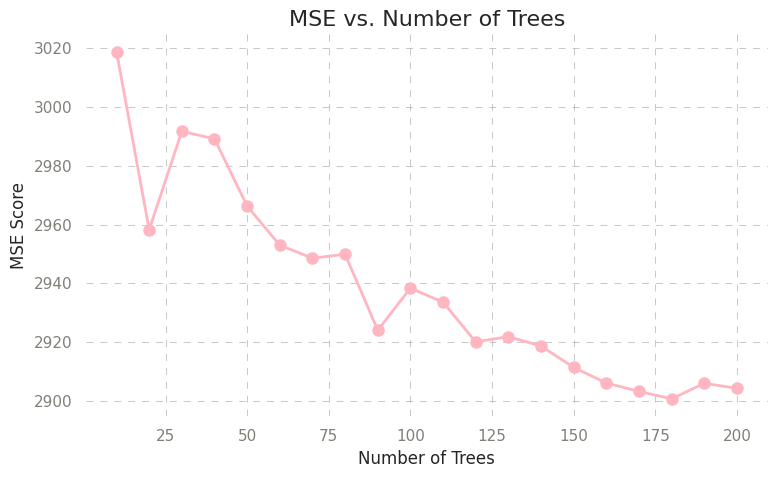


Best n_estimators: 180
Best MSE Score: 2900.731


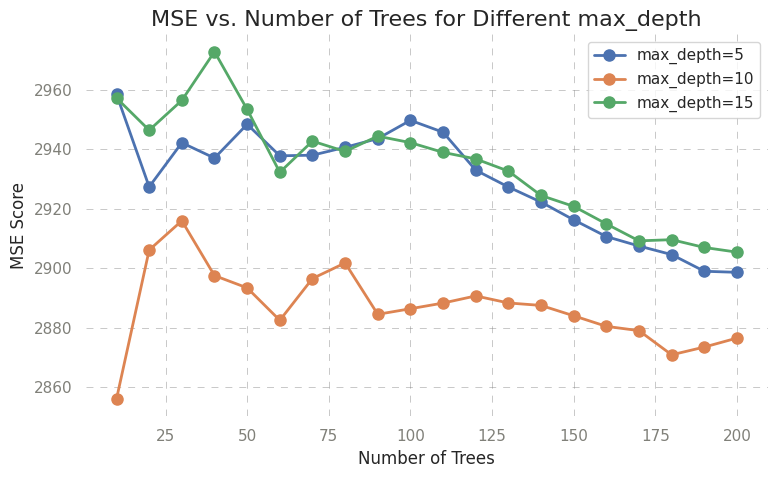

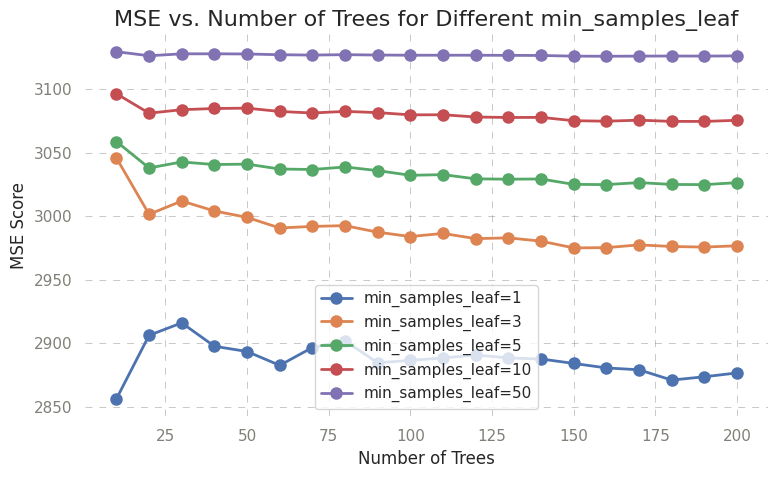


Final Model Performance:
MSE on validation set: 2870.841
RMSE on validation set: 53.580
R² Score on validation set: 0.085


In [51]:
# plot settings
sns.set(style="whitegrid")
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14

def create_styled_plot():
    fig = plt.figure(figsize=(8, 5))
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.grid(True, axis='both', color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)
    ax.tick_params(axis="x", colors="black")
    ax.tick_params(axis="y", colors="black")
    [t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
    [t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]
    return ax

# tuning estimators
scores = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    scores.append((n, mse))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'mse'])

ax = create_styled_plot()
plt.plot(df_scores.n_estimators, df_scores.mse, marker='o', color='#FFB6C1', linewidth=2, markersize=8)
plt.title('MSE vs. Number of Trees', fontsize=16)
plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('MSE Score', fontsize=12)
plt.tight_layout()
plt.savefig('images/mse_vs_num_trees_rf.png', dpi=300, bbox_inches='tight')
plt.show()

# best estimator
best_n_estimators = df_scores.loc[df_scores['mse'].idxmin(), 'n_estimators']
print(f"\nBest n_estimators: {best_n_estimators}")
print(f"Best MSE Score: {df_scores['mse'].min():.3f}")

# tuning max_depth
scores = []
for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        scores.append((d, n, mse))

columns = ['max_depth', 'n_estimators', 'mse']
df_scores = pd.DataFrame(scores, columns=columns)

ax = create_styled_plot()
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.mse, 
             marker='o', linewidth=2, markersize=8,
             label=f'max_depth={d}')

plt.legend()
plt.title('MSE vs. Number of Trees for Different max_depth', fontsize=16)
plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('MSE Score', fontsize=12)
plt.tight_layout()
plt.savefig('images/mse_vs_num_trees_diff_max_depth_rf.png', dpi=300, bbox_inches='tight')
plt.show()

# best max_depth
best_max_depth = df_scores.loc[df_scores['mse'].idxmin(), 'max_depth']

# tuning min_samples_leaf
scores = []
for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(
            n_estimators=n, 
            max_depth=best_max_depth,
            min_samples_leaf=s,
            random_state=42
        )
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        scores.append((s, n, mse))

columns = ['min_samples_leaf', 'n_estimators', 'mse']
df_scores = pd.DataFrame(scores, columns=columns)

ax = create_styled_plot()
for s in [1, 3, 5, 10, 50]:
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.mse,
             marker='o', linewidth=2, markersize=8,
             label=f'min_samples_leaf={s}')

plt.legend()
plt.title('MSE vs. Number of Trees for Different min_samples_leaf', fontsize=16)
plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('MSE Score', fontsize=12)
plt.tight_layout()
plt.savefig('images/mse_vs_num_trees_diff_min_samples_rf.png', dpi=300, bbox_inches='tight')
plt.show()

# best min_samples_leaf
best_min_samples_leaf = df_scores.loc[df_scores['mse'].idxmin(), 'min_samples_leaf']

# train final model with best hyperparameters
rf = RandomForestRegressor(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_leaf=best_min_samples_leaf,
    random_state=42
)
rf.fit(X_train, y_train)

# predictions and metrics
y_pred_val_rf = rf.predict(X_val)
mse = mean_squared_error(y_val, y_pred_val_rf)
rmse = np.sqrt(mse)
r2 = rf.score(X_val, y_val)

print("\nFinal Model Performance:")
print(f"MSE on validation set: {mse:.3f}")
print(f"RMSE on validation set: {rmse:.3f}")
print(f"R² Score on validation set: {r2:.3f}")

In [ ]:
# Hyperparameter tuning results:
# - The best number of trees (n_estimators): 180, achieving an MSE of ~2900.731.
# - The best max_depth: 10, striking a balance between underfitting (depth=5) and overfitting (depth=15).
# - The best min_samples_leaf: 1, enabling the model to capture detailed patterns.
# Final model performance:
# - MSE: 2870.841, RMSE: 53.580, R² Score: 0.085.
# Despite reasonable RMSE, the low R² score (8.5%) suggests limited explanatory power.


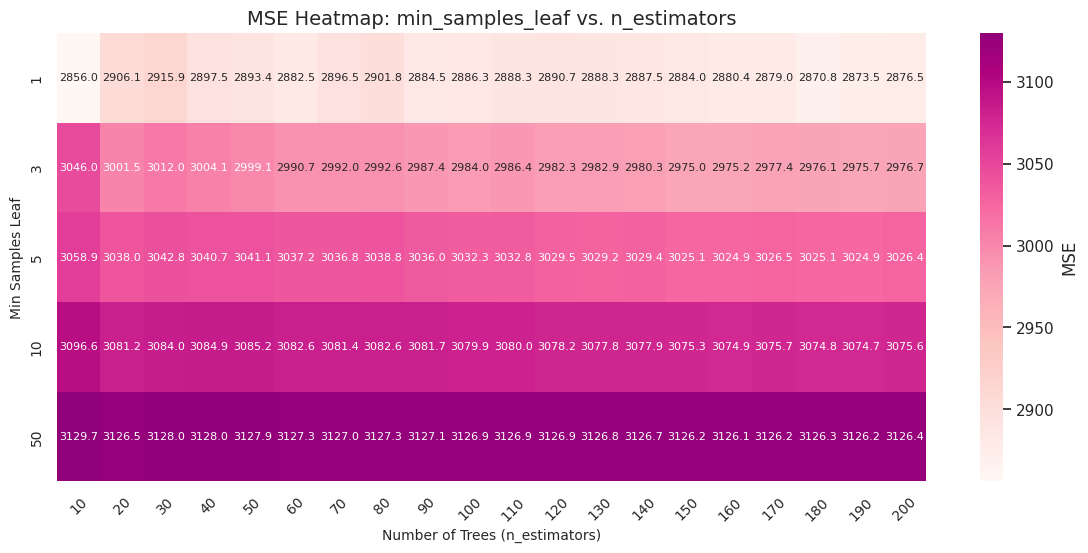

In [54]:
# pivot table 'min_samples_leaf' and 'n_estimators' mse
pivot = df_scores.pivot(index='min_samples_leaf', columns='n_estimators', values='mse')

# style
sns.set(style="whitegrid")
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 12  

# plot
plt.figure(figsize=(12, 6)) 
ax = plt.gca()
sns.heatmap(pivot, 
            annot=True, 
            fmt=".1f", 
            cmap='RdPu', 
            center=pivot.mean().mean(),
            annot_kws={"size": 8}, 
            cbar_kws={'label': 'MSE'}) 

plt.title('MSE Heatmap: min_samples_leaf vs. n_estimators', fontsize=14)
plt.xlabel('Number of Trees (n_estimators)', fontsize=10)
plt.ylabel('Min Samples Leaf', fontsize=10)

# tick parameters
ax.tick_params(axis="x", labelrotation=45, labelsize=10) 
ax.tick_params(axis="y", labelsize=10) 

plt.tight_layout(pad=2.0) 

# save
plt.savefig('images/mse_heatmap_rf.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Key oberservations:


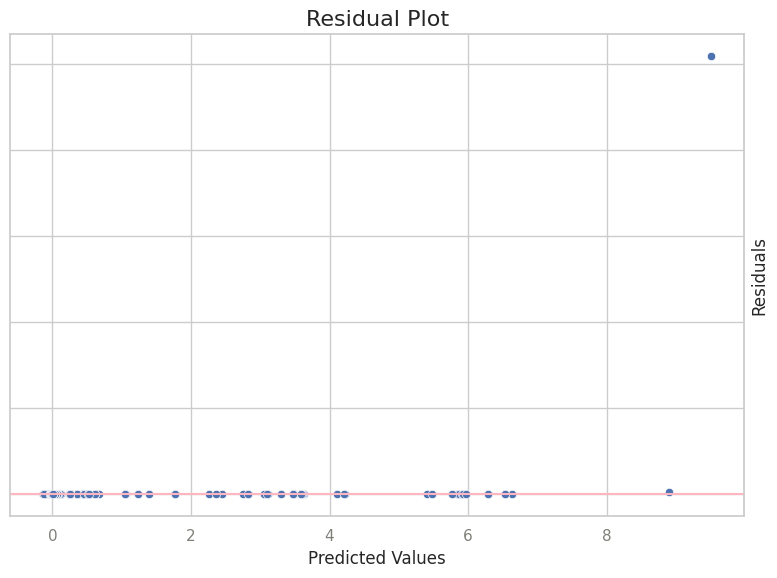

In [68]:
# calculating residuals, residual=y_true - y_pred
residuals = y_val - y_pred

# style
sns.set(style="whitegrid")
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14
plt.figure(figsize=(8, 6))
ax = plt.gca() 

# scatter plot
sns.scatterplot(x=y_pred, y=residuals, ax=ax)
plt.axhline(0, color='#FFB6C1')

# plot title and labels
plt.title('Residual Plot', fontsize=16)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)

# customizing ticks and axis appearance
ax.tick_params(axis="y", colors="black", left=False, labelleft=False)
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# move y-label to the right
ax.yaxis.set_label_position("right")

# display the plot
plt.tight_layout()
plt.savefig('images/residuals_rf.png', dpi=300, bbox_inches='tight')
plt.show()


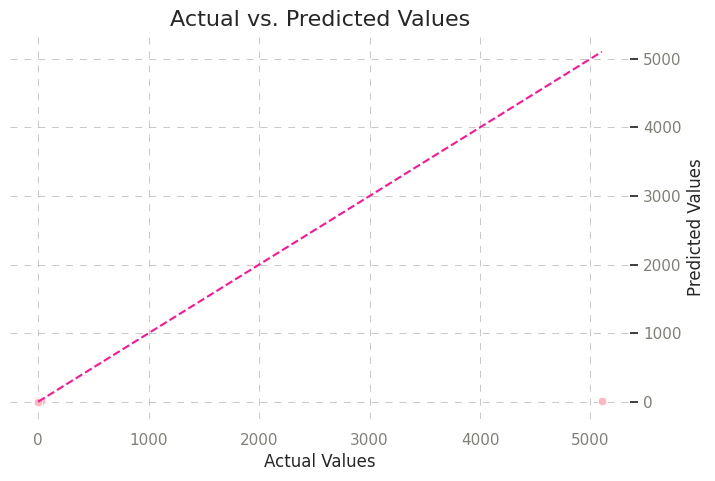

In [69]:
# comparing pred y to val y
plt.figure(figsize=(8, 5))  # Größe angepasst an den Boxplot
sns.scatterplot(x=y_val, y=y_pred, color='#FFB6C1')

# Diagonale Linie (rote Linie)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='#FF1493', linestyle='--')

# title, axis
plt.title('Actual vs. Predicted Values', fontsize=16)
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)

# Stil-Änderungen für Achsen
ax = plt.gca()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

# Entfernen des Rahmens der Achsen
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Gitterlinien
ax.grid(True, color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# Ticks, Labels
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", left=False, labelleft=False)

# Farben der Ticks
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# Plot anzeigen und speichern
plt.savefig('images/scatter_actual_vs_predicted_rf.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Key observations:


## 3.5 XGBoost

In [27]:
from sklearn.metrics import root_mean_squared_error

#define hyperparameter values to be tested
def tune_hyperparameters(eta_values, max_depth_values, min_child_weight_values, X_train, y_train_log, X_val, y_val_log):   
    # list to store results
    scores = []
    # loop through all combinations of the hyperparameters
    for eta in eta_values:
        for max_depth in max_depth_values:
            for min_child_weight in min_child_weight_values:
                # define xgboost parameters
                xgb_params = {
                    'eta': eta,
                    'max_depth': max_depth,
                    'min_child_weight': min_child_weight,
                    'objective': 'reg:squarederror',
                    'eval_metric': 'rmse',
                    'nthread': 8,
                    'seed': 1,
                    'verbosity': 1,
                }
    
                # train model
                model_xgb = xgb.XGBRegressor(**xgb_params)
                model_xgb.fit(X_train, y_train_log)
    
                # predictions on validation
                y_pred_val_log = model_xgb.predict(X_val)

                # transforming back
                y_pred_val_xgb = np.expm1(y_pred_val_log)

                # calculate rmse
                rmse = root_mean_squared_error(np.expm1(y_val_log), y_pred_val_xgb)
                
                # store results
                scores.append((eta, max_depth, min_child_weight, rmse))
    
    # convert results to df
    df_scores = pd.DataFrame(scores, columns=['eta', 'max_depth', 'min_child_weight', 'rmse'])
    
    # find params with lowest RMSE
    best_params = df_scores.loc[df_scores['rmse'].idxmin()]
    return best_params, df_scores


# now using hyperparam funktion
eta_values = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
max_depth_values = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
min_child_weight_values = [1, 3, 5, 7, 9, 10, 12, 13, 14]

best_params, df_scores = tune_hyperparameters(
    eta_values, max_depth_values, min_child_weight_values, X_train, y_train_log, X_val, y_val_log
)

best_eta = best_params['eta']
best_max_depth = best_params['max_depth']
best_min_child_weight = best_params['min_child_weight']

print(f"Best Hyperparameters:\n{best_params}\n")


Best Hyperparameters:
eta                 0.250000
max_depth           5.000000
min_child_weight    1.000000
rmse                1.467122
Name: 468, dtype: float64



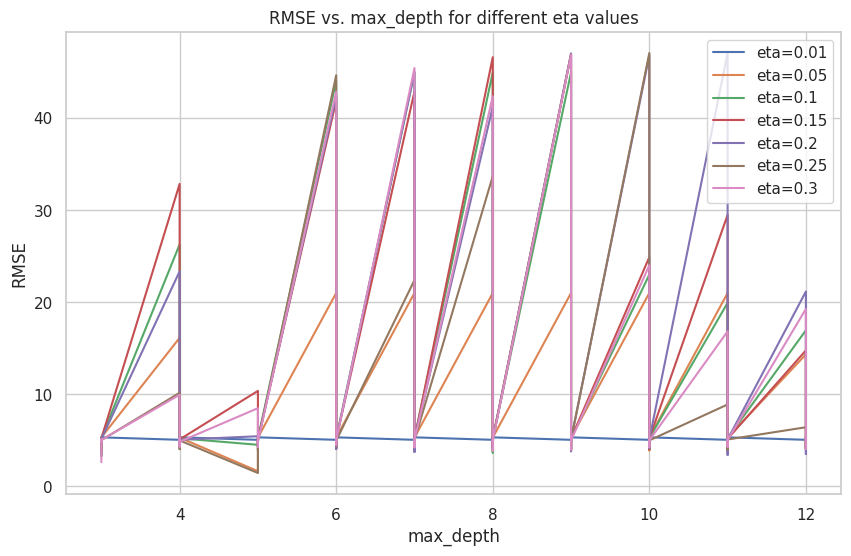

In [34]:
# plot rmse scores for different hyperparameter combinations
fig, ax = plt.subplots(figsize=(10, 6))

for eta in eta_values:
    df_subset = df_scores[df_scores['eta'] == eta]
    ax.plot(df_subset['max_depth'], df_subset['rmse'], label=f'eta={eta}')

# Set plot title and labels
ax.set_title('RMSE vs. max_depth for different eta values')
ax.set_xlabel('max_depth')
ax.set_ylabel('RMSE')
plt.savefig('images/rmse_vs_max_depth_for_diff_eta.png')
ax.legend()
plt.show()


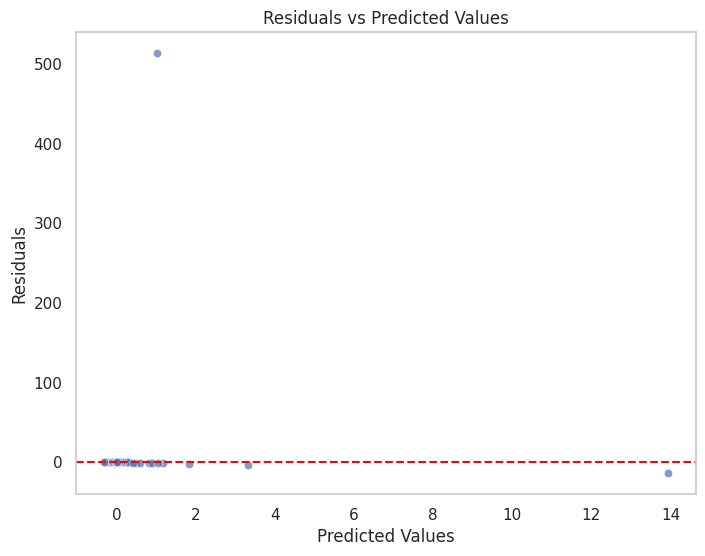

In [35]:
# calculate residuals
residuals = y_val - y_pred

# plot 
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid()
plt.savefig('images/residuals_vs_predicted.png')
plt.show()

XGBoost MSE on the Validation Set: 2.1524
XGBoost MAE on the Validation Set: 0.0163
XGBoost R² Score on the Validation Set: 0.9247


Text(0.5, 1.0, 'Actual vs Predicted Values')

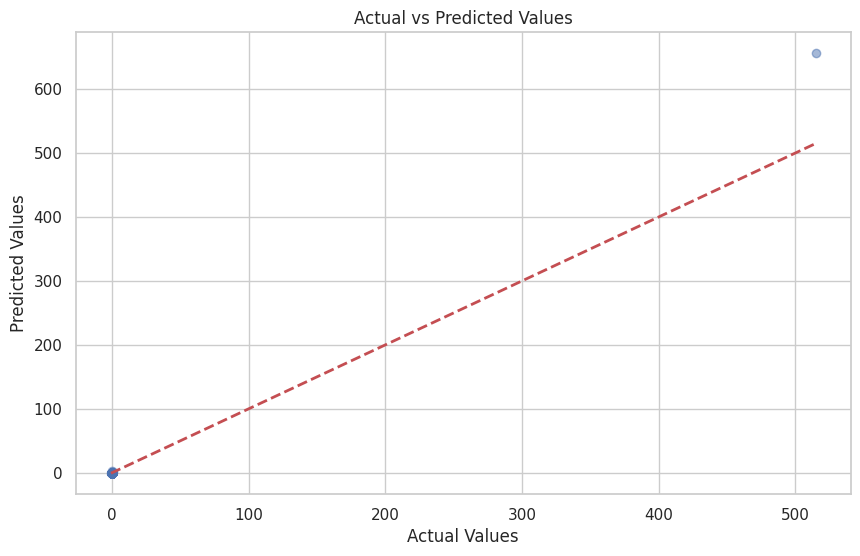

In [44]:
# Apply log transformation to both features and target
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

# Change model to XGBRegressor
model_xgb = xgb.XGBRegressor(
    eta=float(best_eta),
    max_depth=int(best_max_depth),
    min_child_weight=int(best_min_child_weight),
    objective='reg:squarederror',  # Changed to regression objective
    eval_metric='rmse',           # Changed to regression metric
    nthread=8,
    seed=1,
    verbosity=1
)

# Train model with log-transformed data
model_xgb.fit(X_train, y_train_log)

# Make predictions and transform back
y_pred_log = model_xgb.predict(X_val)
y_pred = np.expm1(y_pred_log)

# Evaluate model with transformed back values
mse = mean_squared_error(np.expm1(y_val_log), y_pred)
mae = mean_absolute_error(np.expm1(y_val_log), y_pred)
r2 = r2_score(np.expm1(y_val_log), y_pred)

print(f"XGBoost MSE on the Validation Set: {mse:.4f}")
print(f"XGBoost MAE on the Validation Set: {mae:.4f}")
print(f"XGBoost R² Score on the Validation Set: {r2:.4f}")

# Optional: Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(np.expm1(y_val_log), y_pred, alpha=0.5)
plt.plot([np.expm1(y_val_log).min(), np.expm1(y_val_log).max()], 
         [np.expm1(y_val_log).min(), np.expm1(y_val_log).max()], 
         'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

In [36]:
feature_names = dv.feature_names_
print(feature_names)

['30d_ma', '7d_ma', '7d_volatility', 'adx', 'aroon', 'atr', 'bop', 'cci', 'cmo', 'day', 'fibonacci_0', 'fibonacci_100', 'fibonacci_23_6', 'fibonacci_38_2', 'fibonacci_50', 'fibonacci_61_8', 'growth_168h', 'growth_24h', 'growth_336h', 'growth_48h', 'growth_4h', 'growth_720h', 'growth_72h', 'high', 'hour', 'intraday_range', 'kama', 'ln_volume', 'low', 'macd', 'macd_hist', 'macd_signal', 'mom', 'month', 'open', 'ppo', 'price_change', 'roc', 'rsi', 'sma10', 'sma20', 'ticker=AAVEUSDT', 'ticker=ADAUSDT', 'ticker=BITF', 'ticker=BITO', 'ticker=BLOK', 'ticker=BNBUSDT', 'ticker=BTCUSDT', 'ticker=CL=F', 'ticker=COIN', 'ticker=DAIEUR', 'ticker=DAIUSD', 'ticker=DOGEUSDT', 'ticker=DX-Y.NYB', 'ticker=ETHUSDT', 'ticker=EURUSDC', 'ticker=EURUSDT', 'ticker=FDUSDUSDT', 'ticker=GBTC', 'ticker=GC=F', 'ticker=GLXY.TO', 'ticker=HUT', 'ticker=MARA', 'ticker=MKRUSDT', 'ticker=MSTR', 'ticker=RIOT', 'ticker=SOLUSDT', 'ticker=SQ', 'ticker=TRXUSDT', 'ticker=TUSDUSDT', 'ticker=USDCUSDT', 'ticker=XRPUSDT', 'ticker=^

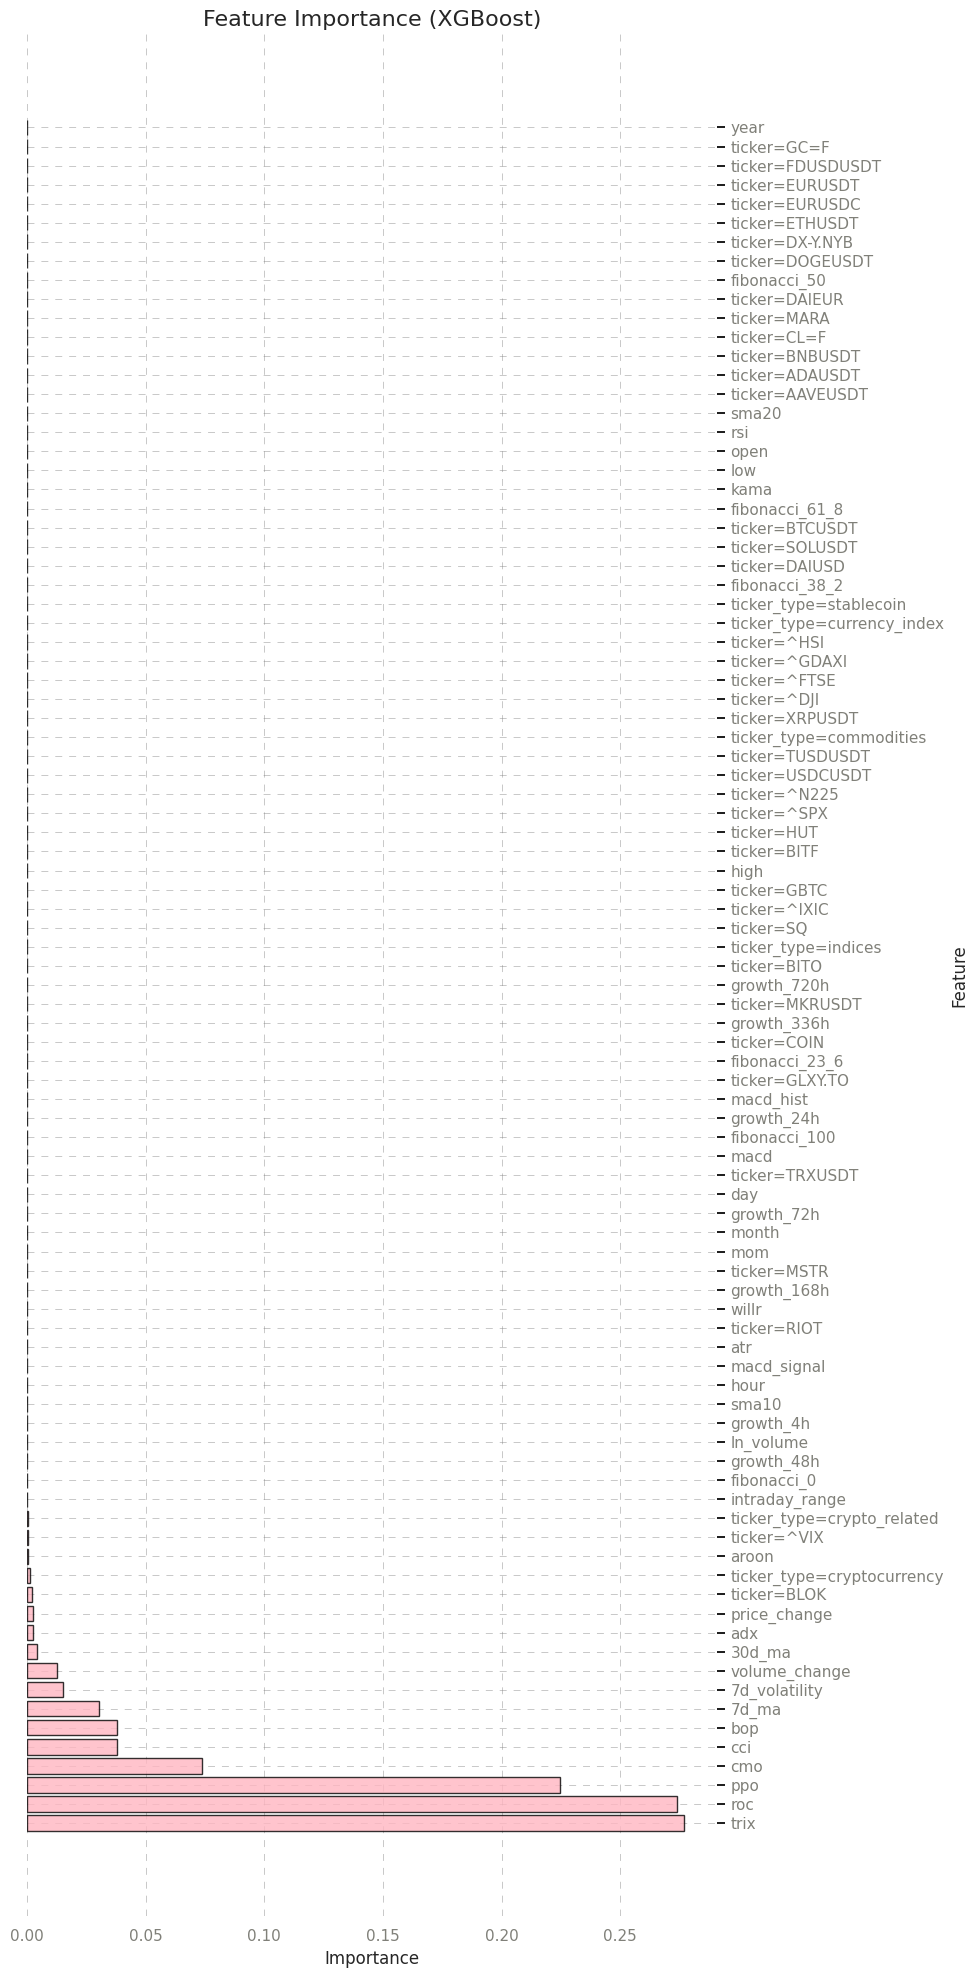

Top 20 Most Important Features:
                       Feature  Importance
86                        trix    0.277021
37                         roc    0.273897
35                         ppo    0.224805
8                          cmo    0.073828
7                          cci    0.038161
6                          bop    0.037862
1                        7d_ma    0.030314
2                7d_volatility    0.015313
87               volume_change    0.012719
0                       30d_ma    0.004150
3                          adx    0.002689
36                price_change    0.002395
45                 ticker=BLOK    0.002172
82  ticker_type=cryptocurrency    0.001290
4                        aroon    0.000622
79                 ticker=^VIX    0.000551
81  ticker_type=crypto_related    0.000273
25              intraday_range    0.000186
10                 fibonacci_0    0.000163
19                  growth_48h    0.000124


In [47]:
# calculate feature importance for the final model
feature_importances = model_xgb.feature_importances_

# create df for better visualization
feature_importance_df = pd.DataFrame({
   'Feature': feature_names, 
   'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# plot setup - made figure taller
plt.figure(figsize=(10, 20))  # adjusted dimensions to be more vertical
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14

# create barplot
plt.barh(feature_importance_df['Feature'], 
        feature_importance_df['Importance'],
        color='#FFB6C1',
        alpha=0.8,
        edgecolor="black")

# title and labels
plt.title("Feature Importance (XGBoost)", fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# axis styling
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# move ticks to right side
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

# ticks styling
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", colors="black", left=False, labelleft=False)
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]

# grid
ax.grid(True, axis='both', color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# layout
plt.tight_layout()

# save
plt.savefig('images/feature_importance_xgboost.png', dpi=300, bbox_inches='tight')
plt.show()

# Print top 20 features and their importance values
print("Top 20 Most Important Features:")
print(feature_importance_df.head(20))

In [48]:
import shap

# SHAP (SHapley Additive exPlanations) explains how each feature impacts the model's prediction
# provides both global and local explanations 
# -> importance of a feature + how a specific feature affects the prediction of a particular data point
# positive value means the feature pushes the prediction higher, while a negative value means it pushes it lower

explainer = shap.Explainer(model_xgb, X_train)
hap_values = explainer(X_train)

# shows average importance of each feature in the model
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=20)

# beeswarm plot, more detailed visualization, showing how the SHAP values for each feature vary
shap.summary_plot(shap_values, X_train)

# force_plot function, shows different features impact the prediction for a specific instance
shap.force_plot(explainer.expected_value, shap_values[0, :], X_train.iloc[0, :])


ModuleNotFoundError: No module named 'shap'

In [91]:
# adjust model now with features
important_features = feature_importance_df[feature_importance_df['Importance'] > 0.001]['Feature']
X_train_filtered = pd.DataFrame(X_train, columns=feature_names)[important_features]
X_val_filtered = pd.DataFrame(X_val, columns=feature_names)[important_features]
X_test_filtered = pd.DataFrame(X_test, columns=feature_names)[important_features]

best_params, df_scores = tune_hyperparameters(
    eta_values, max_depth_values, min_child_weight_values, X_train_filtered, y_train, X_val_filtered, y_val
)      
            
# retrain
model_xgb_retrained = xgb.XGBClassifier(
    eta=float(best_eta),
    max_depth=int(best_max_depth),
    min_child_weight=int(best_min_child_weight),
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    nthread=8,
    seed=1,
    verbosity=1
)

# Train model
model_xgb_retrained.fit(X_train_filtered, y_train)
            
# Make probabilistic predictions
y_pred_val_proba_retrained = model_xgb_retrained.predict_proba(X_val_filtered)[:, 1]

# Convert probabilities to binary predictions with a threshold
y_pred_val_retrained = (y_pred_val_proba_retrained >= 0.55).astype(int)

# Evaluate binary classification metrics
print(f"XGBoost Accuracy on the Validation Set: {accuracy_score(y_val, y_pred_val_retrained)}")
print(f"XGBoost Confusion Matrix on the Validation Set:\n{confusion_matrix(y_val, y_pred_val_retrained)}")
print(f"XGBoost Classification Report on the Validation Set:\n{classification_report(y_val, y_pred_val_retrained)}")
print(f"XGBoost F1-Score on the Validation Set: {f1_score(y_val, y_pred_val_retrained)}")

# Evaluate continuous metrics
print(f"XGBoost ROC-AUC on the Validation Set: {roc_auc_score(y_val, y_pred_val_proba_retrained)}")

XGBoost Accuracy on the Validation Set: 0.5601279788172993
XGBoost Confusion Matrix on the Validation Set:
[[3364 1309]
 [2678 1713]]
XGBoost Classification Report on the Validation Set:
              precision    recall  f1-score   support

           0       0.56      0.72      0.63      4673
           1       0.57      0.39      0.46      4391

    accuracy                           0.56      9064
   macro avg       0.56      0.55      0.55      9064
weighted avg       0.56      0.56      0.55      9064

XGBoost F1-Score on the Validation Set: 0.462161068393363
XGBoost ROC-AUC on the Validation Set: 0.5925523302800707


In [ ]:
# after various tests, no feature can be left out
# the model decreases in performance if a treshhold for features are set, so using the first one

In [95]:
# Save the besst model
with open('model_xgb.pkl', 'wb') as file:
    pickle.dump(model_xgb, file)

#save features and parameter
with open('features.pkl', 'wb') as file:
    pickle.dump((X_train, X_val, y_train, y_val), file)

In [ ]:
# Model Comparison Summary:
# - XGBoost performed the best with the highest F1-score (0.64) and ROC-AUC (0.594).
# - It achieved a good balance between precision and recall for class 1, especially handling imbalanced data.
# - Random Forest was second-best but had a lower F1-score (0.51) and ROC-AUC (0.557).
# - Decision Tree and Logistic Regression underperformed due to simpler structures and inability to model complex patterns.
# - XGBoost is recommended for final deployment with potential improvements via feature engineering and Bayesian optimization.


In [ ]:
!
# 1. Nehme das beste Modell (z.B. der Random Forest mit den besten Hyperparametern)
best_model = RandomForestRegressor(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_leaf=best_min_samples_leaf,
    random_state=42
)

# 2. Trainiere es auf ALLEN verfügbaren Daten
# (nicht nur X_train, sondern X_train + X_val zusammen)
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])
best_model.fit(X_full, y_full)

# 3. Nun kannst du neue Daten vorhersagen:
# Beispiel für neue Daten (müssen gleiche Features wie X_train haben)
new_data = pd.DataFrame({
    'feature1': [value1],
    'feature2': [value2],
    # ... alle Features die auch im Training waren
})

# Vorhersage machen
prediction = best_model.predict(new_data)
print(f"Vorhergesagter Wert: {prediction[0]}")